<a href="https://colab.research.google.com/github/raissamiranda/Classificacao-em-aprendizado-de-maquina-supervisionado/blob/main/TP1_ALG2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classificação em aprendizado de máquina supervisionado

---

> Gabriela Moraes Miserani de Freitas - 2020006566

> Raissa Miranda Maciel - 2020006965





Este trabalho possui o objetivo de solucionar o problema de classificação em aprendizado de máquina supervisionado através do uso de algoritmos de geometria computacional, em especial, os de criação de envoltória convexa e verificação de interseção em um conjunto de segmentos.

Com base em um conjunto de dados de treinamento, o problema consiste em criar um modelo que os represente e seja capaz de atribuir o valor para uma nova amostra desse conjunto, caso esses dados sejam linearmente separáveis. Dessa forma, o modelo possui o propósito de "aprender" com os dados de treinamento a fim de rotular/classificar amostras desconhecidas.

Por fim, será possível avaliar o desempenho do classificador através da execução de diversos experimentos com conjuntos de dados reais, em que o modelo será treinado com 70% deles. Os 30% restantes serão utilizados para teste do classificador e 3 métricas serão utilizadas para mensurar a taxa de acertos com os dados desconhecidos.

# Imports iniciais

In [60]:
!pip install bintrees
import functools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import bintrees
from copy import deepcopy
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import precision_recall_fscore_support
from random import randint


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Funcões auxiliares para visualização



Essas funções serão utilizadas para a visualização do processo de criação das envoltórias e do modelo.

In [61]:
# Cria lista com as coordenadas x
def coordenadas_x(Q):
  cords_x = []
  for i in Q:
    cords_x.append(i[0])
  return cords_x


# Cria lista com as coordenadas y
def coordenadas_y(Q):
  cords_y = []
  for i in Q:
    cords_y.append(i[1])
  return cords_y


# Plota apenas os pontos
def plota_dados_iniciais(L1, L2):
  plt.rcParams["figure.figsize"] = (16,10)
  ax = plt.axes() 
  ax.set_facecolor("#FFFAF0") 
  plt.rcParams["figure.figsize"] = (16,10)
  plt.scatter(coordenadas_x(L1), coordenadas_y(L1), color='#8B008B')
  plt.scatter(coordenadas_x(L2), coordenadas_y(L2), color='#FF1493')
  plt.xlabel('x', color='#1C2833')
  plt.ylabel('y', color='#1C2833')
  plt.legend(["Classe 0", "Classe 1"], loc = "lower right", fontsize = 15)
  plt.title("Dados iniciais", fontsize = 20)


# Recoloca o primeiro ponto na ultima posicao pra conectar a ultima reta
def conecta_retas(Q):
  copia = deepcopy(Q)
  copia.append(Q[0])
  return copia


# Plota a envoltoria e os pontos dentro
def plota_envoltorias(piniciais1, piniciais2):
  #axes=plt.gca()
  #axes.grid()
  #axes.axis('auto')
  ax = plt.axes() 
  ax.set_facecolor("#FFFAF0")
  plt.rcParams["figure.figsize"] = (16,10)
  env1 = graham_scan(piniciais1)
  env2 = graham_scan(piniciais2)
  e1 = conecta_retas(env1)
  e2 = conecta_retas(env2) 
  plt.scatter(coordenadas_x(piniciais1), coordenadas_y(piniciais1), color='#8B008B')
  plt.scatter(coordenadas_x(piniciais2), coordenadas_y(piniciais2), color='#FF1493')
  plt.plot(coordenadas_x(e1), coordenadas_y(e1), color='#8B008B')
  plt.plot(coordenadas_x(e2), coordenadas_y(e2), color='#FF1493')


# Plota so a envoltoria sem os pontos
def plota_so_envoltoria(env1,env2):
  ax = plt.axes() 
  ax.set_facecolor("#FFFAF0")
  plt.rcParams["figure.figsize"] = (16,10)
  e1 = conecta_retas(env1)
  e2 = conecta_retas(env2) 
  plt.plot(coordenadas_x(e1), coordenadas_y(e1), color='#8B008B')
  plt.plot(coordenadas_x(e2), coordenadas_y(e2), color='#FF1493')


# Plota reta que conecta pontos mais proximos das envoltorias
def plota_reta_conectando_envoltorias(piniciais1, piniciais2):
  plota_envoltorias(piniciais1, piniciais2)
  envoltoria1 = graham_scan(piniciais1)
  envoltoria2 = graham_scan(piniciais2)
  p1,p2 = pontos_proximos(envoltoria1, envoltoria2)
  px = [p1[0], p2[0]]
  py = [p1[1], p2[1]]
  plt.plot(px, py, color='#CD5C5C')
  plt.title('Reta conectando envoltorias')
  plt.xlabel('x', color='#1C2833')
  plt.ylabel('y', color='#1C2833')
  plt.legend(loc='upper left')


# Plota envoltorias com pontos, reta conectando, ponto medio e reta modelo
def plota_modelo_completo(piniciais1, piniciais2):
  # plot envoltorias
  e1 = graham_scan(piniciais1)
  e2 = graham_scan(piniciais2)
  plota_envoltorias(piniciais1, piniciais2)
  # plot pontos mais proximos
  p1,p2 = pontos_proximos(e1, e2)
  px = [p1[0], p2[0]]
  py = [p1[1], p2[1]]
  plt.plot(px, py, color='#CD5C5C')
  # plot ponto medio
  pm = ponto_medio(p1,p2)
  x= pm[0]
  y= pm[1]
  plt.plot(x, y, marker='*', markersize=10, markeredgecolor="black")
  # plot reta unindo pontos e modelo
  p1_seg, p2_seg = seg_modelo(e1,e2)
  plt.plot(([p1_seg[0], p2_seg[0]]), (p1_seg[1], p2_seg[1]), color='#1E90FF')
  # configs
  plt.xlabel('x', color='#1C2833')
  plt.ylabel('y', color='#1C2833')
  plt.title('Modelo completo')
  plt.legend(loc='upper left')


# Plota apenas a envoltoria e a reta modelo
def plota_modelo_limpo(piniciais1 ,piniciais2):
  e1 = graham_scan(piniciais1)
  e2 = graham_scan(piniciais2)
  plota_so_envoltoria(e1,e2)
  plt.xlabel('x', color='#1C2833')
  plt.ylabel('y', color='#1C2833')
  p1_seg, p2_seg = seg_modelo(e1,e2)
  plt.plot(([p1_seg[0], p2_seg[0]]), (p1_seg[1], p2_seg[1]), color='#1E90FF')
  plt.title('Modelo')
  plt.legend(loc='upper left')
  plt.legend(["Classe 0", "Classe 1"], loc = "lower right", fontsize = 10)

# Problema inicial:


Durante a implementação e explicação dos algoritmos será mostrado graficamente a criação do modelo com pontos arbitrários criados apenas para demonstração e entendimento do processo. Esses pontos representam as duas classes de um problema fictício. e podem ser visualizados abaixo:

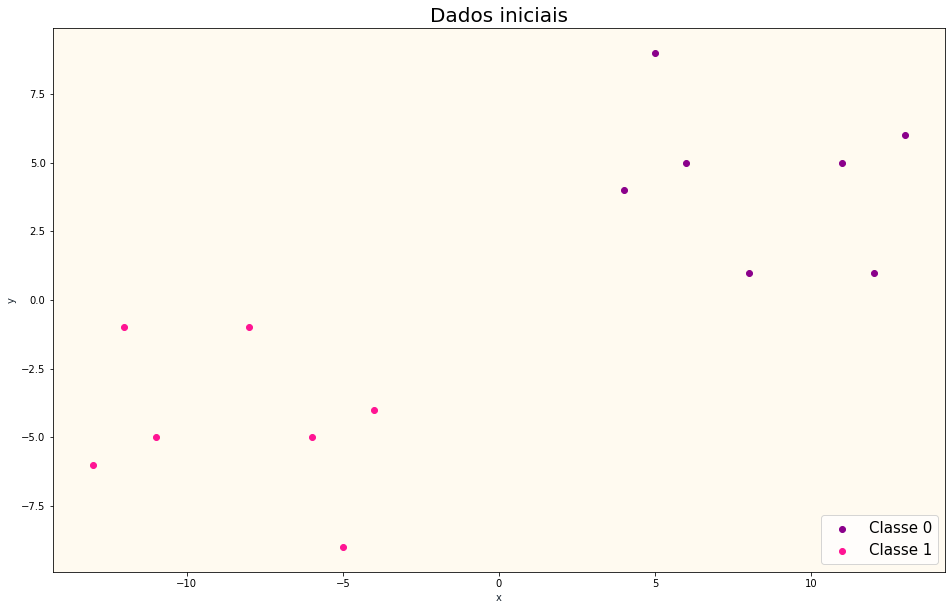

In [62]:
classe_0 = [(5,9), (13,6), (11,5), (8,1), (12,1), (4,4), (6,5)]
classe_1 = [(-5,-9), (-13,-6), (-11,-5), (-8,-1), (-12,-1), (-4,-4), (-6,-5)]

plota_dados_iniciais(classe_0, classe_1)

# 1. Envoltória convexa



Para que o modelo seja criado, é necessário verificar se as duas classes são linearmente separáveis. Considerando que as amostras são representadas por um conjunto de pontos, sendo as variáveis x e y atributos que as descrevem, dados linearmente separáveis são aqueles em que as duas classes distintas não ocupam a mesma região no espaço.

Sendo assim, inicialmente, é utilizado um método que compute as envoltórias convexas de cada classe para verificar se há interseção entre elas. Para esse fim, foi implementado o algoritmo Graham-Scan dada sua facilidade e eficiência.


> **Algoritmo Graham-Scan**:

> Encontrar a envoltória convexa consiste em encontrar o menor polígono convexo que contenha todos os pontos de um conjunto, ou seja, os pontos desse conjuntos estão ou dentro ou na borda da envoltória.

> O algoritmo inicia-se identificando o ponto âncora como aquele de menor coordenada y, e, caso haja empate, o de menor coordenada x (como este ponto é o mais abaixo, com certeza fará parte da envoltória). A partir dele serão processados todos os outros pontos em sentido anti-horário. Para isso, é necessário que sejam ordenados de acordo com o ângulo polar em relação ao ponto âncora (em caso de empate, mantém-se o mais distante).

> Com os pontos ordenados, as iterações do algoritmo consistem em verificar a direção da rota dos pontos $p_{i-1}$ $p_i$ $p_{i+1}$ a partir do ponto âncora. Como a verificação é em sentido anti-horário, para $p_i$ ser adicionado, deve haver uma mudança de direção para a esquerda. Caso haja uma mudança de direção para direita, $p_i$ é um ponto interno e deve ser descartado. Nesse caso, deve-se repetir o teste de direção para a rota $p_{i-2}$ $p_{i-1}$ $p_{i+1}$ até que se encontre a conversão para esquerda.

> Após o processamento de todos os pontos, o algoritmo retorna aqueles que fazem parte da envoltória.

> Este algoritmo possui complexidade temporal dominada pela ordenação dos pontos $O(n\cdot logn)$, uma vez que a busca pelo ponto âncora, o cálculo dos ângulos polares e a geração da envoltória são $O(n)$.

A seguir há a implementação de funções primitivas ($O(1))$ utilizadas para o pré-processamento do algoritmo: orientação relativa de segmentos, direção da rota por segmento, método de ordenação e outras funções auxiliares.

In [63]:
# p_ancora eh variavel global
p_ancora = 0


# Encontra o indice do ponto ancora, aquele com menor coordenada y
# Em caso de empate: menor coordenada x
def indice_ancora(Q):
  ancora = Q[0]
  indice = 0
  for i in range(len(Q)):
    x = Q[i][0]
    y = Q[i][1]
    if((y < ancora[1]) or (ancora[1] == y and Q[i][0] < ancora[0])):
      ancora = Q[i]
      indice = i
  return indice  


# Retorna o p_ancora
def p_ancora(Q):
  return Q[indice_ancora(Q)]


# Troca de posicao os pontos das posicoes i e j
def swap(Q, i, j):
  p_aux = Q[i]
  Q[i] = Q[j]
  Q[j] = p_aux


# Encontra o produto vetorial da rota p1p2 e p1p3
def produto_vetorial(p1, p2, p3):
  prod_vetorial = ((p2[0] - p1[0]) * (p3[1] - p1[1]) -
                   (p3[0] - p1[0]) * (p2[1] - p1[1]))
  return prod_vetorial


# Calcula distancia entre dois pontos
def distancia(p1, p2):
  return ((p1[0] - p2[0]) * (p1[0] - p2[0]) + (p1[1] - p2[1] * p1[1] - p2[1]))


# Usada para ordenar todos os pontos de acordo com o menor angulo polar
# em relacao a um ponto ancora
def menor_cord_polar(p1, p2):
  # p1 e p2 sao colineares, escolhe o mais distante de p0
  if (produto_vetorial(p_ancora, p1, p2) == 0):
    if(distancia(p_ancora, p1) >= distancia(p_ancora, p2)):
      return -1
    else: 
      return 1
  else: 
    # mudanca de direcao pra esquerda nao troca a ordem
    # (p1 ja eh o menor angulo polar)
    if(produto_vetorial(p_ancora, p1, p2) < 0):
      return 1
    else:
      # mudanca de direcao pra direita troca a ordem
      # (p2 eh o menor angulo polar) 
      return -1


# Topo da pilha
def top(Q):
  return Q[len(Q)-1]


# Next to top da pilha
def next_to_top(Q):
  return Q[len(Q)-2]


# Retira o ponto colinear que tem menor distancia
# Considerando que o mais distante esta a direita de acordo com a ordenacao
def trata_colineares(Q):
  global p_ancora
  for i in range(len(Q)):
    while( (i < len(Q)-1) and produto_vetorial(p_ancora, Q[i], Q[i+1]) == 0):
        if(distancia_pontos(p_ancora, Q[i]) >= distancia_pontos(p_ancora, Q[i+1])):
          del(Q[i+1])
        else:
          del(Q[i])
          i = i -1

Implementação do algoritmo Graham-Scan:

In [64]:
# Graham Scan: computa os pontos da envoltoria convexa
def graham_scan(Q):
  # Para a lista original de pontos nao ser alterada
  copia_Q = deepcopy(Q)
  # Acha indice do ponto ancora
  i_ancora = indice_ancora(copia_Q)
  # Coloca o ponto ancora na primeira posicao da lista
  swap(copia_Q, i_ancora, 0)
  # Ordena todos os pontos em relacao a p_ancora, pela menor cord polar
  global p_ancora
  p_ancora = copia_Q[indice_ancora(copia_Q)]
  del(copia_Q[0])
  pontos_ordenados = sorted(copia_Q, key=functools.cmp_to_key(menor_cord_polar))
  # Analisa pontos colineares, deixando o de maior distancia
  trata_colineares(pontos_ordenados)
  # Calcula pontos da envoltoria
  envoltoria = []
  envoltoria.append(p_ancora)
  envoltoria.append(pontos_ordenados[0])
  envoltoria.append(pontos_ordenados[1])
  for i in range(2, len(pontos_ordenados)):
    # Vira pra direita: nao faz parte da envoltoria, analisa recursivamente os anteriores
    while produto_vetorial(next_to_top(envoltoria), top(envoltoria), pontos_ordenados[i]) < 0:
      envoltoria.pop()
    # Vira pra esquerda: adiciona proximo ponto para analise
    envoltoria.append(pontos_ordenados[i])
  # Retorna os pontos que fazem parte da envoltoria
  return(envoltoria)

As envoltórias do problema fictício criado são visualizadas a seguir:

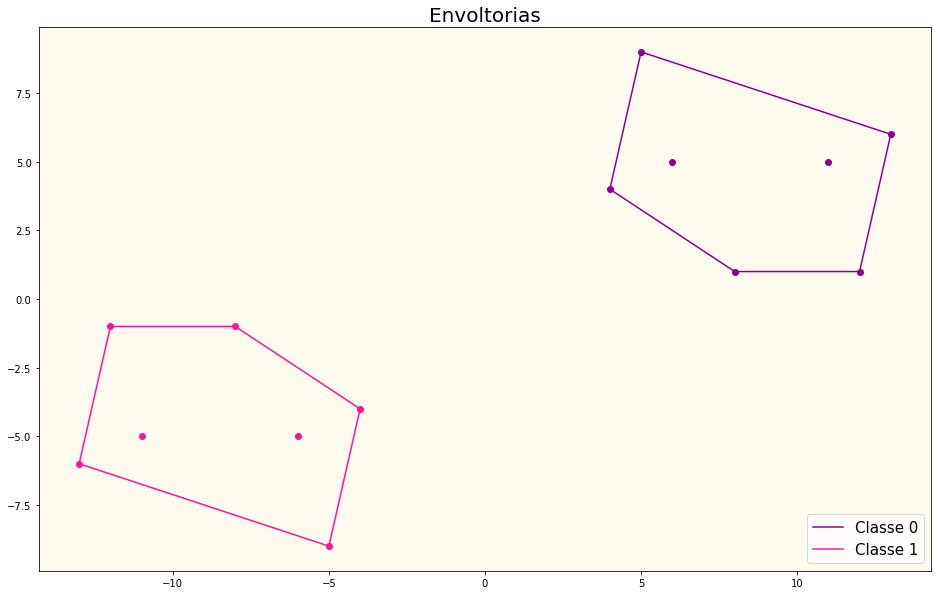

In [65]:
plota_envoltorias(classe_0, classe_1)
plt.title("Envoltorias", fontsize = 20)
plt.legend(["Classe 0", "Classe 1"], loc = "lower right", fontsize = 15)

# 2. Varredura Linear










Ainda com o objetivo de verificar a separabilidade linear dos dados, é necessário analisar se há sobreposição das envoltórias computadas anteriormente. Para isso, é usado um método que identifica essas possíveis interseções. O algoritmo de varredura linear foi implementado em função da sua eficiência tanto pela escolha de uma estrutura de dados eficiente quanto pela técnica de detectar interseção entre dois segmentos.

> **Algoritmo de varredura linear**

> Esse algoritmo é capaz de identificar a interseção entre quaisquer dois elementos de um conjunto de segmentos. No contexto desse problema, serão utilizados os segmentos que compõem as envoltórias de cada classe e será reportada a interseção caso ela aconteça entre segmentos de envoltórias distintas.

> Assim como o nome diz, é realizada uma varredura da esquerda para direita por uma reta vertical imaginária que cruzará os segmentos e analisará se há interseção entre os consecutivos sempre que encontrar um ponto terminal (ponto inicial ou final). Por isso, o pré-processamento do algoritmo é ordenar os segmentos em relação a coordenada x (em caso de empate, prefere-se os pontos iniciais e de menor coordenada y).

> Para controlar quais são os segmentos comparáveis na medida em que segmentos começam e terminam (entram e saem da relação de comparação), é necessário uma estrutura de dados que insira, remova e encontre segmentos consecutivos. Esse algoritmo implementado utiliza a árvore balanceada AVL.

> Dessa forma, a estrutura possui caráter dinâmico e se altera durante o processamento da varredura enquanto compara os segmentos imediatamente superiores e inferiores ao segmento que entra ou sai da relação. Assim que encontrar uma interseção, ela é reportada e o algoritmo termina. É importante ressaltar que as comparações são feitas apenas entre segmentos de classes diferentes, e por isso, é criado um tipo abstrato para o segmento que possui o identificador da classe.

> Este algoritmo possui complexidade temporal dominada pela ordenação inicial dos pontos $O(n\cdot logn)$, uma vez que as iterações ocorrem no máximo pelos  $2n$ pontos terminais, a função primitiva de verificação de interseção entre dois segmentos é $O(1)$ e a árvore AVL realiza as operações em $O(logn)$.

A seguir são implementadas as funções primitivas, método de ordenação e outras funções auxiliares para realizar a varredura.

In [66]:
# Um segmento possui um ponto inicial (pi),
#                    um ponto final (pf),
#                    um id que indica de qual envoltoria faz parte (id)
class Segmento:
  def __init__(self, pi = None, pf = None, id = None):
    self.pi = pi
    self.pf = pf
    self.id = id


# Printa o ponto inicial e final de um segmento
def printa_segmento(s):
  print("(", s.pi, ", ", s.pf, ", id= ", s.id, ")")


# Cria lista de segmentos a partir de uma lista de pontos consecutivos
def cria_segmentos(Q, id):
  segmentos = []
  for i in range(0, len(Q)-1):
    # Sempre criar segmentos tais que os pontos iniciais são os de menor x
    p1 = Q[i]
    p2 = Q[i+1]
    seg_aux1 = Segmento(p1, p2, id)
    seg_aux2 = Segmento(p2, p1, id)
    if(p1[0] < p2[0]):
      segmentos.append(seg_aux1)
    else:
      segmentos.append(seg_aux2)
  # Cria o segmento do ultimo ponto com o primeiro
  pf = Q[len(Q)-1]
  p0 = Q[0]
  if(p0[0] < pf[0]):
    segmentos.append(Segmento(p0, pf, id))
  else:
    segmentos.append(Segmento(pf, p0, id))
  return segmentos


# Recebe duas listas de segmentos e retorna uma lista de eventos
# um evento é uma quadrupla (p, d, i, id)
# p = ponto
# d = define se o ponto eh inicial ou final (0 -> inicial, 1 -> final)
# i = indice do ponto na lista de segmentos
# id = id da sua envoltoria
def define_eventos(Q1, Q2):
  # Lista de eventos para cada envoltoria
  eventos1 = []
  eventos2 = []
   # Cria lista de eventos para Q1 e Q2
  for i in range(len(Q1)):
    eventos1.append((Q1[i].pi, 0, i, Q1[i].id))
    eventos1.append((Q1[i].pf, 1, i, Q1[i].id))
  for i in range(len(Q2)):
    eventos2.append((Q2[i].pi, 0, i, Q2[i].id))
    eventos2.append((Q2[i].pf, 1, i, Q2[i].id))
  # Junta todos os eventos em uma lista
  return eventos1 + eventos2


# Define valores de acordo com a direcao da rota (direita/esquerda)
def direcao_rota(p0, p1, p2):
  if (produto_vetorial(p0, p1, p2) > 0):
    return 1
  elif (produto_vetorial(p0, p1, p2) < 0):
    return -1
  else:
    return 0


# Verifica se, p1 esta sobre o segmento p0p2
def esta_no_segmento(p0, p1, p2):
  if(p2[0] <= max(p0[0], p2[0]) and p2[0] >= min(p0[0], p2[0]) and
     p2[1] <= max(p0[1], p2[1]) and p2[1] >= min(p0[1], p2[1])):
    return True
  else:
    return False


# Primitiva de verificacao de intersecao entre dois segmentos s1 e s2
def ha_intersecao (s1, s2):
  # Segmentos da mesma envoltoria nao precisam ser comparados
  if (s1.id == s2.id): 
    return False
  # Pontos segmento 1
  p1i = s1.pi
  p1f = s1.pf
  # Pontos segmento 2
  p2i = s2.pi
  p2f = s2.pf
  # Computa a direcao das rotas
  r1 = direcao_rota(p1i, p1f, p2i)
  r2 = direcao_rota(p1i, p1f, p2f)
  r3 = direcao_rota(p2i, p2f, p1i)
  r4 = direcao_rota(p2i, p2f, p1f)
  # Caso geral
  if (r1 != r2 and r3 != r4):
    return True
  # Caso: p1i, p1f, p2i sao colineares e p2i esta sobre o segmento 1
  if (r1 == 0 and esta_no_segmento(p1i, p2i, p1f)): return True
  # Caso: p1i, p1f, p2f sao colineares e p2f esta sobre o segmento 1
  if (r2 == 0 and esta_no_segmento(p1i, p2f, p1f)): return True
  # Caso: p2i, p2f, p1i sao colineares e p1i esta sobre o segmento 2
  if (r3 == 0 and esta_no_segmento(p2i, p1i, p2f)): return True
  # Caso: p2i, p2f, p1f sao colineares e p1f esta sobre o segmento 2
  if (r4 == 0 and esta_no_segmento(p2i, p1f, p2f)): return True
  # Nenhum dos casos
  return False


# Compara a coordenada x para ser usada na funcao sorted
def menor_x(e1, e2):
  if(e1[0][0] < e2[0][0]):
    return -1
  elif(e1[0][0] > e2[0][0]):
    return 1
  # Caso os dois eventos possuam o mesmo x, desempata se for inicial
  else:
    if(e1[1] != e2[1]):
      if(e1[1] == 0):
        return -1
      else:
        return 1
    # Os dois eventos sao ou iniciais ou finais (iguais)
    else:
      if(e1[0][1] < e2[0][1]):
        return -1
      # Se sao o mesmo evento (sao pontos iniciais de segmentos diferentes por ex)
      else:
        return 1
    

# Ordena uma lista de eventos de acordo com a coordenada x
def ordena_eventos(Q, env1, env2):
  #eventos_ordenados = sorted(Q, key=functools.cmp_to_key(menor_x))
  segs1 = cria_segmentos(env1, 1)
  segs2 = cria_segmentos(env2, 2)
  eventos_ordenados = ajusta_eventos(Q, segs1, segs2)
  return eventos_ordenados


# Acha segmento em uma lista de acordo com o indice
def acha_segmento(Q1, Q2, e):
  if(e[3] == 0):
    return Q1[e[2]]
  else:
    return Q2[e[2]]


# Determina se existe um sucessor a uma chave na arvore
# (o segmento consecutivo de cima)
def is_above(avl, chave, terminal):
  # Se for ponto inicial
  if(terminal == 0):
    # Tenta achar sucessor
    try:
      # Retorna a chave e pega o sucessor dela
      avl.succ_key(chave)
    # Se nao houver sucessor
    except:
      return False
    return True
  # Se for ponto final, procura chave
  if(avl.__contains__(chave)):
    try:
      avl.succ_item(chave)[0]
      return True
    except:
      return False
  # Nao tem a chave na avl
  else:
    try:
      # Procura a menor chave igual ou maior do que a chave buscada
      avl.ceiling_item(chave)[0]
      return True
    except:
      return False


# Determina se existe um antecessor a uma chave na arvore
# (o segmento consecutivo de baixo)
def is_below(avl, chave, terminal):
  # Se for ponto inicial
  if(terminal == 0):
    # Tenta achar antecessor
    try:
      avl.prev_key(chave)
    except:
      return False
    return True
  # Se for ponto final e tem a chave
  if(avl.__contains__(chave)):
    try:
      avl.prev_item(chave)
      return True
    except:
      return False
  # Nao tem a chave na avl
  else:
    try:
      # Procura a maior chave igual ou menor do que a chave buscada
      avl.floor_item(chave)
      return True
    except:
      return False


# Verifica se ha intersecao entre um segmento e o segmento sucessor e antecessor
# Abstraindo: verifica se intercepta com o segmento em cima e em baixo
def segmentos_consecutivos_interceptam(seg, avl,  suc = False, ant = False):
  try:
    # Se houver sucessor
    if (suc):
      seg_suc = avl.succ_item(seg.pi[1])[1]
      return ha_intersecao(seg, seg_suc)
    # Se houver antecessor
    if(ant):
      seg_ant = avl.prev_item(seg.pi[1])[1]
      return ha_intersecao(seg, seg_ant)
  except:
    # Se nao houver nenhum dos dois (ele esta sozinho)
    return False

In [67]:
# Ordena os eventos de acordo com a coordenada x, adicionando um ruido para eventos iguais
# (pra quando adicionar essas chaves na estrutura da varredura, nao serem vistos como o mesmo ponto)   
def ajusta_eventos(eventos, s1, s2):
  if (len(eventos)) <= 1: return eventos
  # Separa os eventos de forma a colocar os eventos iguais em ordem pela coordenada y do outro ponto terminal do segmento
  # (util quando for add na arvore, comparar os antecessores e sucessores corretamente)
  p = eventos[len(eventos)//2]  
  menor = []
  mesmo_evento = [] 
  maior = []
  # Verifica a qual envoltoria os eventos pertencem
  if p[3] == 0: p_final_y = s1[p[2]].pf[1] 
  else: p_final_y = s2[p[2]].pf[1]
  # Analisa cada evento, segue as prioridades:
  # menor x do ponto inicial
  # ponto inicial antes de ponto final
  # menor y do ponto final do segmento dos eventos
  for e in eventos:
    if e[0][0] < p[0][0]: menor.append(e)
    else:
      if e[0][0] > p[0][0]: maior.append(e)
      else:
        if e[1] != p[1]:  # Caso sejam tipos de eventos distintos
          if e[1] == 0: menor.append(e)
          else: maior.append(e)
        else:
          if e[0][1] < p[0][1]: menor.append(e)
          else:
            if e[0][1] > p[0][1]: maior.append(e)
            else:
              if e[3] == 0:
                if s1[e[2]].pf[1] > p_final_y: maior.append(((e[0][0], e[0][1] + 0.0000001), e[1], e[2], e[3]))
                else:
                  if s1[e[2]].pf[1] < p_final_y: menor.append(((e[0][0], e[0][1] - 0.0000001), e[1], e[2], e[3]))
                  else: mesmo_evento.append(e)
              else: 
                if s2[e[2]].pf[1] > p_final_y: maior.append(((e[0][0], e[0][1] + 0.0000001), e[1], e[2], e[3]))
                else:
                  if s2[e[2]].pf[1] < p_final_y: menor.append(((e[0][0], e[0][1] - 0.0000001), e[1], e[2], e[3]))
                  else: mesmo_evento.append(e)
  return ajusta_eventos(menor, s1, s2) + mesmo_evento + ajusta_eventos(maior, s1, s2)

Algoritmo de Varedura:

In [68]:
# Analisa se ha intersecao entre segmentos de dois conjuntos(classes/envoltorias)
def intersecao_no_conjunto(Q1, Q2):
  # Arvore AVL
  T = bintrees.AVLTree()
  # Cria segmentos de cada envoltoria
  segmentosQ1 = cria_segmentos(Q1, 0)
  segmentosQ2 = cria_segmentos(Q2, 1)
  # Cria eventos das duas envoltorias
  eventos = define_eventos(segmentosQ1, segmentosQ2)
  # Cria uma lista com todos os eventos ordenados
  eventos_ordenados = ordena_eventos(eventos, Q1, Q2)
  # Testa eventos
  for i in eventos_ordenados:
    # Acha o segmento do evento
    seg = acha_segmento(segmentosQ1, segmentosQ2, i)
    # Para ponto inicial, adiciona na arovre
    if i[1] == 0:
      chave = seg.pi[1]
      T.insert(chave, seg)
      # Checa se ha intersecao entre os segmentos consecutivos ao que estamos testando
      if(is_above(T, chave, 0) and segmentos_consecutivos_interceptam(seg, T, True, False)):
        return True
      if(is_below(T, chave, 0) and segmentos_consecutivos_interceptam(seg, T, False, True)):
        return True
    # Se for ponto final, tira ele da arvore e olha se ha intersecao com os novos consecutivos
    else:
      chave = seg.pf[1]
      # Ver se tem um segmento em cima e embaixo do segmento
      if(is_above(T, chave, 1) and is_below(T, chave, 1)):
        # Verifica se ha intersecao entre esses novos segmentos consecutivos
        # depois que o "do meio" foi retirado, ja que seu evento eh de ponto final
        if(ha_intersecao(T.ceiling_item(chave)[1], T.floor_item(chave)[1])):
          return True
      T.pop(seg.pi[1], 'error')
  return False

In [69]:
# Debugger
'''pontos1 = [(0, 10), (2, -5), (4, 7), (6, -3), (5, 9), (12, 2), (-3, 6), (2,2), (5,1)]
pontos3 = [(1,1), (3,2), (0,5), (2,4), (-2,-1), (3,1), (-3,2), (-1,1), (-3,6)]

envoltoria1 = graham_scan(pontos1)
envoltoria2 = graham_scan(pontos3)
plota_envoltorias(pontos1, pontos3)

print("Pontos envoltoria: ", envoltoria1)
segmentos1 = cria_segmentos(envoltoria1, 0)

print("Pontos envoltoria: ", envoltoria2)
segmentos2 = cria_segmentos(envoltoria2, 1)

print("Segmentos1: ")
for i in segmentos1:
  printa_segmento(i)

print("Segmentos2: ")
for i in segmentos2:
  printa_segmento(i)

print("Eventos: ")
eventos = define_eventos(segmentos1, segmentos2)
print(eventos)

print("Eventos ordenados: ")
print(ordena_eventos(eventos, envoltoria1, envoltoria2))

print("Envoltorias se interceptam: ", intersecao_no_conjunto(envoltoria1, envoltoria2))'''

'pontos1 = [(0, 10), (2, -5), (4, 7), (6, -3), (5, 9), (12, 2), (-3, 6), (2,2), (5,1)]\npontos3 = [(1,1), (3,2), (0,5), (2,4), (-2,-1), (3,1), (-3,2), (-1,1), (-3,6)]\n\nenvoltoria1 = graham_scan(pontos1)\nenvoltoria2 = graham_scan(pontos3)\nplota_envoltorias(pontos1, pontos3)\n\nprint("Pontos envoltoria: ", envoltoria1)\nsegmentos1 = cria_segmentos(envoltoria1, 0)\n\nprint("Pontos envoltoria: ", envoltoria2)\nsegmentos2 = cria_segmentos(envoltoria2, 1)\n\nprint("Segmentos1: ")\nfor i in segmentos1:\n  printa_segmento(i)\n\nprint("Segmentos2: ")\nfor i in segmentos2:\n  printa_segmento(i)\n\nprint("Eventos: ")\neventos = define_eventos(segmentos1, segmentos2)\nprint(eventos)\n\nprint("Eventos ordenados: ")\nprint(ordena_eventos(eventos, envoltoria1, envoltoria2))\n\nprint("Envoltorias se interceptam: ", intersecao_no_conjunto(envoltoria1, envoltoria2))'

# 3. Verificação de separabilidade dos dados


Com a utilização dos algoritmos descritos anteriormente, é possível definir se duas classes são linearmente separáveis criando suas respectivas envoltórias e verificando se há sobreposição entre elas.

O método a seguir verifica a separabilidade.

In [70]:
# Define se dois conjuntos de dados sao separaveis
def dados_separaveis(Q1,Q2):
  env1 = graham_scan(Q1)
  env2 = graham_scan(Q2)
  if(intersecao_no_conjunto(env1,env2)):
    print("Dados nao linearmente separaveis!")
  else:
    print("Dados linearmente separaveis!")

Para o problema fictício, de fato, as classes não se sobrepõem:

In [71]:
dados_separaveis(classe_0, classe_1)

Dados linearmente separaveis!


# 4. Construção do modelo

Uma vez que os dados são linearmente separáveis, é possível criar um modelo que represente esses dados.

O primeiro passo é encontrar a reta que une os dois pontos mais próximos entre as duas envoltórias.

Abaixo estão implementadas as funções que cumprem esse objetivo.

In [72]:
# Calcula a distancia entre dois pontos
def distancia_pontos(p1,p2):
  return ((p2[0]-p1[0])**2 + (p2[1]-p1[1])**2)


# Encontra os dois pontos mais proximos de duas envoltorias
def pontos_proximos(Q1, Q2):
  menor_distancia = distancia_pontos(Q1[0], Q2[0])
  pmin_Q1 = Q1[0]
  pmin_Q2 = Q2[0]
  for i in Q1:
    for j in Q2:
      if(distancia_pontos(i,j) < menor_distancia):
        menor_distancia = distancia_pontos(i,j)
        pmin_Q1 = i
        pmin_Q2 = j
  # Coloca o ponto com menor x como o inicial
  if(pmin_Q1[0] < pmin_Q2[0]):
    return pmin_Q1, pmin_Q2
  else:
    return pmin_Q2, pmin_Q1


# Encontra os coeficientes da equacao da reta a partir de dois pontos
# y = ax + b
def equacao_reta(p1, p2):
  if p1[0] == p2[0]: 
    # Reta que conecta pontos mais proximos eh horizontal, mediatriz vertical
    a = 500
  else:
    # Reta que conecta pontos mais proximos eh vertical, mediatriz horizontal
    if(p1[1] == p2[1]):
      a = 0
    else:
      # Caso qualquer
      a = (p2[1]-p1[1])/(p2[0]-p1[0])
  b = p1[1] - a*p1[0]
  return a, b

Seguindo com o problema fictício temos:

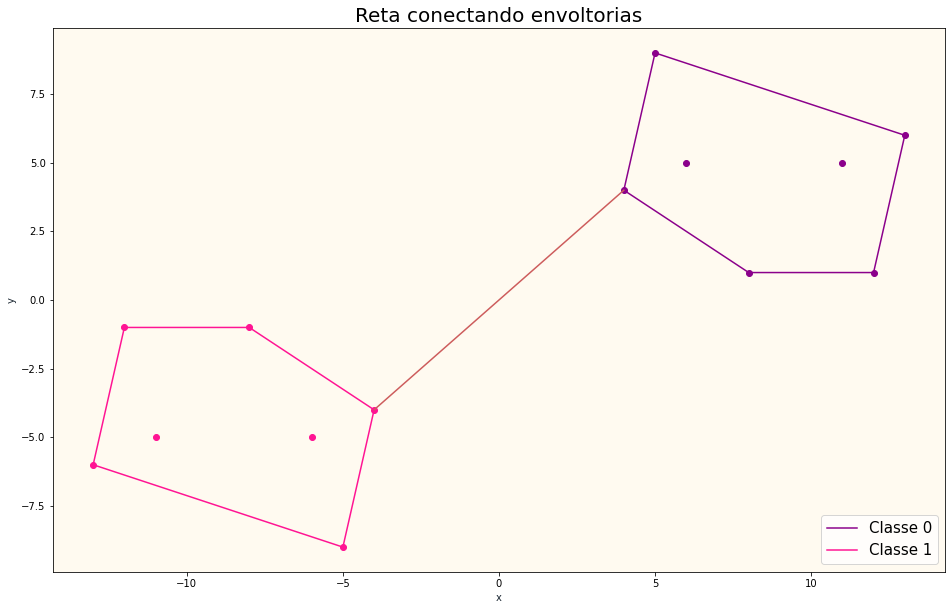

In [73]:
plota_reta_conectando_envoltorias(classe_0, classe_1)
plt.title("Reta conectando envoltorias", fontsize = 20)
plt.legend(["Classe 0", "Classe 1"], loc = "lower right", fontsize = 15)

Em seguida, identifica-se o ponto médio entre os dois pontos mais próximos anteriormente encontrados e, a reta perpendicular ao segmento que os une e passa pelo ponto médio, é o modelo a ser reportado.

A seguir estão os métodos que implementam essa funcionalidade.


In [74]:
# Calcula ponto medio entre dois pontos em uma reta
def ponto_medio(p1, p2):
  return ((p1[0] + p2[0])/2, (p1[1] + p2[1])/2)


# Calcula o coeficiente a da reta mediatriz
# y = ax + b
def equacao_mediatriz(pm, a):
  # Mediatriz horizontal
  if(a == 0):
    a_mediatriz = 0
  else:
    # Mediatriz vertical
    if(a == 500):
      a_mediatriz = 500
    # Caso geral
    else:
      a_mediatriz = (-1)/a
  b_mediatriz = pm[1] - a_mediatriz*pm[0]
  return a_mediatriz, b_mediatriz


# Encontra o ponto de maior e menor coordenada x e y de uma envoltoria
# Usado para plotar o segmento do modelo
def pontos_terminais(env):
  pmin_x = env[0][0]
  pmin_y = env[0][1]
  pmax_x = env[0][0]
  pmax_y = env[0][1]
  for i in range(1, len(env)):
    if(env[i][0] < pmin_x): pmin_x = env[i][0]
    if(env[i][1] < pmin_y): pmin_y = env[i][1]
    if(env[i][0] > pmax_x): pmax_x = env[i][0]
    if(env[i][1] > pmax_y): pmax_y = env[i][1]
  return pmin_x, pmin_y, pmax_x, pmax_y


# Encontra dois pontos do modelo vertical para tracar o segmento
def pontos_modelo(env1, env2, a, b, pm):
  # Calcula os minimos das envoltorias
  p1min_x, p1min_y, p1max_x, p1max_y = pontos_terminais(env1)
  p2min_x, p2min_y, p2max_x, p2max_y = pontos_terminais(env2)
  # Encontra o ponto mais alto e mais baixo
  xmin = min(p1min_x, p2min_x)
  ymin = min(p1min_y, p2min_y)
  xmax = max(p1max_x, p2max_x)
  ymax = max(p1max_y, p2max_y)
  # Mediatriz vertical
  if(a == 0):
    p1 = (pm[0], ymin)
    p2 = (pm[0], ymax)
  else:
    # Mediatriz horizontal
    if(a == 500):
      p1 = (xmin, pm[1])
      p2 = (xmax, pm[1])
    else:
      am, bm = equacao_mediatriz(pm, a)
      p2 = ((ymin-bm)/am, ymin)
      p1 = ((ymax-bm)/am, ymax)
  return p1, p2


# Encontra o segmento do modelo para duas envoltorias
def seg_modelo(env1, env2):
  # Pontos mais proximos entre duas envoltorias
  p1, p2 = pontos_proximos(env1, env2)
  # Coeficientes da equacao da reta que une os dois pontos
  a, b = equacao_reta(p1, p2)
  # Ponto medio desse segmento
  pm = ponto_medio(p1,p2)
  # Equacao da reta mediatriz
  a_mediatriz, b_mediatriz = equacao_mediatriz(pm, a)
  # Encontra os pontos do segmento da mediatriz
  p1_seg, p2_seg = pontos_modelo(env1, env2, a, b, pm)
  return p1_seg, p2_seg

O modelo fictício com a visualização das retas e pontos usadas para sua construção é mostrado abaixo:

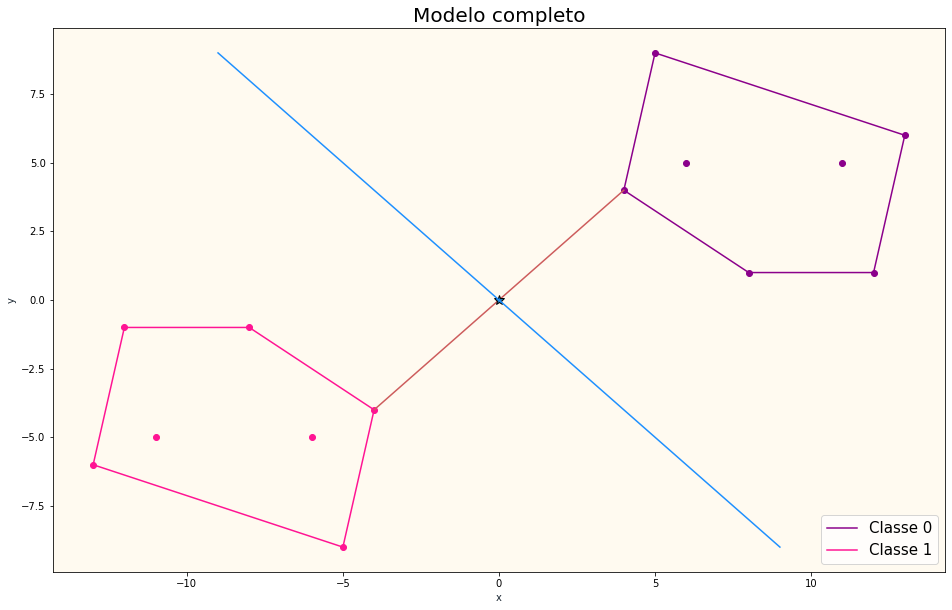

In [75]:
plota_modelo_completo(classe_0, classe_1)
plt.title("Modelo completo", fontsize = 20)
plt.legend(["Classe 0", "Classe 1"], loc = "lower right", fontsize = 15)

A visualização simplificada do modelo também é mostrada:

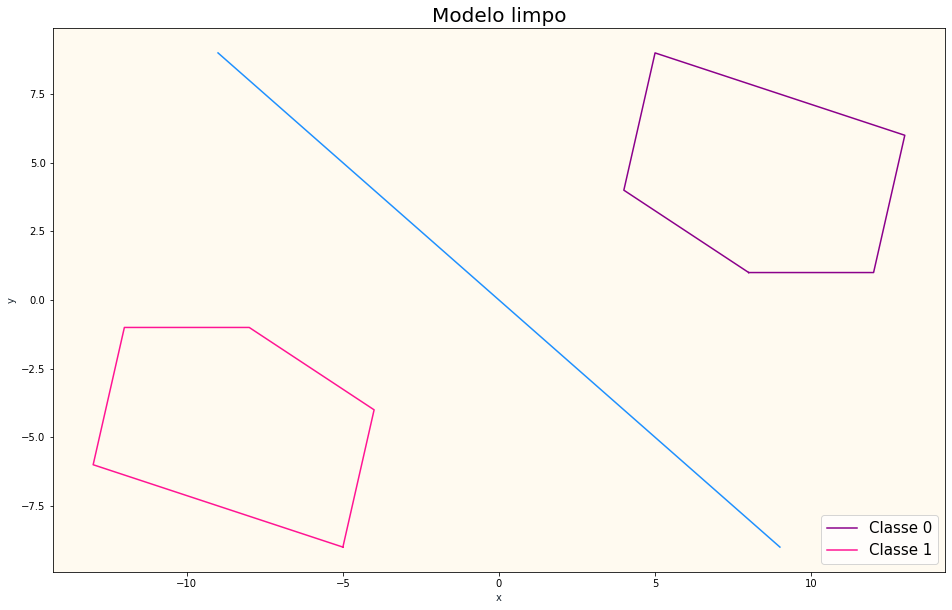

In [76]:
plota_modelo_limpo(classe_0, classe_1)
plt.title("Modelo limpo", fontsize = 20)
plt.legend(["Classe 0", "Classe 1"], loc = "lower right", fontsize = 15)

# 5. Classificador

O classificador possui a funcionalidade de identificar a qual classe uma nova amostra pertence. Tendo em vista as estruturas criadas, o modelo atribui um novo ponto a determinada classe se ele se localizar na mesma região que a sua respectiva envoltória, sendo a reta modelo a divisória de regiões. Para esse objetivo, é novamente utilizada a primitiva de direção da rota por segmentos para identificar qual envoltória está à esquerda ou à direita da reta. Com isso, verifica-se também a direção da rota com o novo ponto e atribui o rótulo de acordo com a classe daquela região.

No contexto desse programa, como mencionado anteriormente, o modelo é criado com dados de treinamento relativo a 70% do conjunto de dados original e os 30% restantes são usados como amostras desconhecidas para testar o classificador. Sendo assim, o método *classificador* recebe todos os pontos teste e o nome dos rótulos a qual as duas envoltórias pertencem, respectivamente, para gerar uma lista com os rótulos dos pontos teste obtidos com o modelo.

In [77]:
# Retorna uma lista com os ids(nome da classe) de cada ponto teste
def classificador(env1, env2, id1, id2, pontos_teste):
  # Encontra os pontos que formam o segmento do modelo
  p1_seg, p2_seg = seg_modelo(env1, env2)
  # Usa um ponto da envoltoria1 para definir a direcao da classe1
  penv1 = env1[0]
  if(direcao_rota(p1_seg, p2_seg, penv1) == -1):
    esq = id1
    dir = id2
  else:
    esq = id2
    dir = id1
  # Cria uma lista com a classe a qual cada ponto teste pertence, em ordem
  resultado_classificacoes = []
  for i in range(len(pontos_teste)):
    if(direcao_rota(p1_seg, p2_seg, pontos_teste[i]) == -1):
      resultado_classificacoes.append(esq)
    else:
      resultado_classificacoes.append(dir)
  return resultado_classificacoes

Testando o ponto $(-10,5)$ como uma nova amostra para o problema fictício e atribuindo os rótulos $"bom$ _ $aluno"$ e $"mau$ _ $aluno"$ para as classes $0$ e $1$ criadas, primeiro analisamos visualmente que essa nova amostra deve pertencer a classe $"mau$ _ $aluno"$.

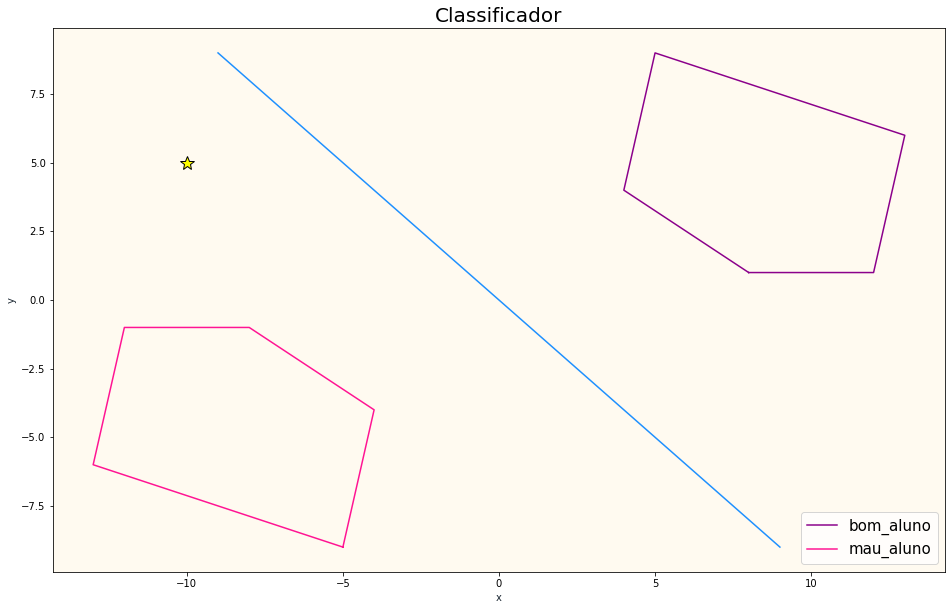

In [78]:
plota_modelo_limpo(classe_0, classe_1)
plt.title("Classificador", fontsize = 20)
plt.plot(-10, 5, marker='*', markersize=15, markeredgecolor="black", color='yellow')
plt.legend(["bom_aluno", "mau_aluno"], loc = "lower right", fontsize = 15)

Verificando qual rótulo o modelo atribui a nova amostra:

In [79]:
nova_amostra = [(-10,5)]
env0 = graham_scan(classe_0)
env1 = graham_scan(classe_1)
classificador(env0, env1, "bom_aluno", "mau_aluno", nova_amostra)

['mau_aluno']

Testando também para o ponto $(8,-4)$, percebe-se visualmente que essa nova amostra deve pertencer a classe $"bom$ _ $aluno"$.

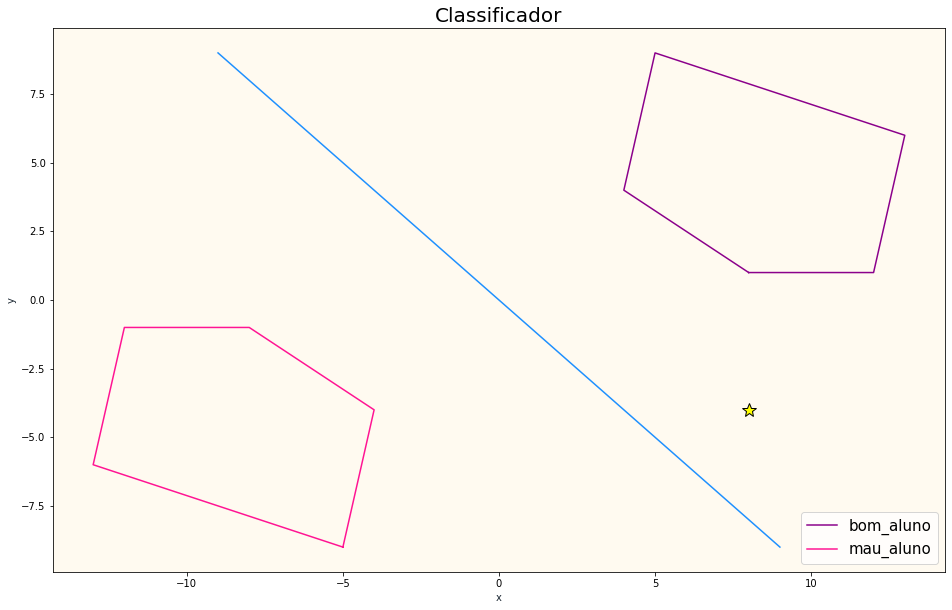

In [80]:
plota_modelo_limpo(classe_0, classe_1)
plt.title("Classificador", fontsize = 20)
plt.plot(8, -4, marker='*', markersize=15, markeredgecolor="black", color='yellow')
plt.legend(["bom_aluno", "mau_aluno"], loc = "lower right", fontsize = 15)

Verificando qual rótulo o modelo atribui a nova amostra:

In [81]:
nova_amostra2 = [(8,-4)]
classificador(env0, env1, "bom_aluno", "mau_aluno", nova_amostra2)

['bom_aluno']

O modelo criado conseguiu rotular corretamente as duas novas amostras testadas!

# 6. Métricas de classificação

Para computar as métricas de classificação, usadas para avaliar o desempenho do modelo criado, serão usados os 30% dos dados que não compuseram o treinamento do modelo. Ao comparar os rótulos obtidos e os rótulos originais das amostras teste, é possível mensurar a taxa de acertos. As métricas precisão, revocação e f1-escore utilizadas para essa avaliação foram obtidas através da biblioteca Scikit-Learn.

In [82]:
# Retorna 2 listas, uma com 70% dos pontos para treino, outra com 30% dos pontos para teste
def dados_treino_teste(classe, col_x, col_y):
  pontos_treino = []
  pontos_teste = []
  x = classe[col_x]
  y = classe[col_y]
  x_treino, x_teste, y_treino, y_teste = train_test_split(x, y, test_size = 0.3, random_state = 100)
  for i in range(0, len(x_treino)):
    xtr = x_treino.iloc[i]
    ytr = y_treino.iloc[i]
    pontos_treino.append((xtr,ytr))
  for i in range(0,len(x_teste)):
    xte = x_teste.iloc[i]
    yte = y_teste.iloc[i]
    pontos_teste.append((xte,yte))
  return pontos_treino, pontos_teste


# Funcao que retorna a lista de rotulos das amostras teste e das originais de treino
# com a lista dos rotulos originais que esses pontos pertencem
# id1 e id2 sao as colunas do dataframe (atributos usados)
# pontos_teste ja eh a uniao dos pontos de teste das duas classes
def resultados_teste_e_original(piniciais1, piniciais2, id1, id2, pontos_teste_classe1, pontos_teste_classe2):
  env1 = graham_scan(piniciais1)
  env2 = graham_scan(piniciais2)
  # Os pontos originais ficarao em uma lista ordenados, os da classe1 com seu id1 seguidos da classe2 com seu id2
  classe1_original = [id1]*(len(pontos_teste_classe1))
  classe2_original = [id2]*(len(pontos_teste_classe2))
  res_original = classe1_original + classe2_original
  #print(res_original)
  # Usa os pontos teste para calcular de acordo com o modelo (na mesma ordem)
  pontos_teste = pontos_teste_classe1 + pontos_teste_classe2
  res_modelo = classificador(env1, env2, id1,  id2,  pontos_teste)
  #print(res_modelo)
  return res_original, res_modelo


# Calcula as 3 metricas precision, recall e fscore
def calcula_metricas(res_teste, res_original):
  precision, recall, fscore, support = precision_recall_fscore_support(res_teste, res_original, average='micro')
  print('Precision: {:.4f}'.format(precision))
  print('Recall: {:.4f}'.format(recall))
  print('Fscore: {:.4f}'.format(fscore))

# 7. Experimentos


Para avaliar o classificador, são realizados a seguir dez experimentos com bases de dados reais extraídas do repositório de dados do software de análise de dados [KEEL](https://sci2s.ugr.es/keel/category.php?cat=clas#inicio).

### 1. Bananas


Esse conjunto de dados prevê o formato da fruta através de dois atributos não identificados. Dessa forma, os 2 formatos distintos são os rótulos das classes e os atributos são as coordenadas utilizadas para a construção do modelo.

A seguir, a visualização do dataframe:

In [83]:
df_banana = pd.read_csv('./banana.csv', delimiter=',')

df_formato1 = df_banana[df_banana['Class'] == 1.0]
df_formato2 = df_banana[df_banana['Class'] == -1.0]

formato1_treino, formato1_teste = dados_treino_teste(df_formato1, 'At1', 'At2')
formato2_treino, formato1_teste = dados_treino_teste(df_formato2, 'At1', 'At2')

df_banana.head()

,At1,At2,Class
0,1.140,-0.114,-1.0
1,-1.520,-1.150,1.0
2,-1.050,0.720,-1.0
3,-0.916,0.397,1.0
4,-1.090,0.437,1.0


Checando a separabilidade linear das classes:

Dados nao linearmente separaveis!


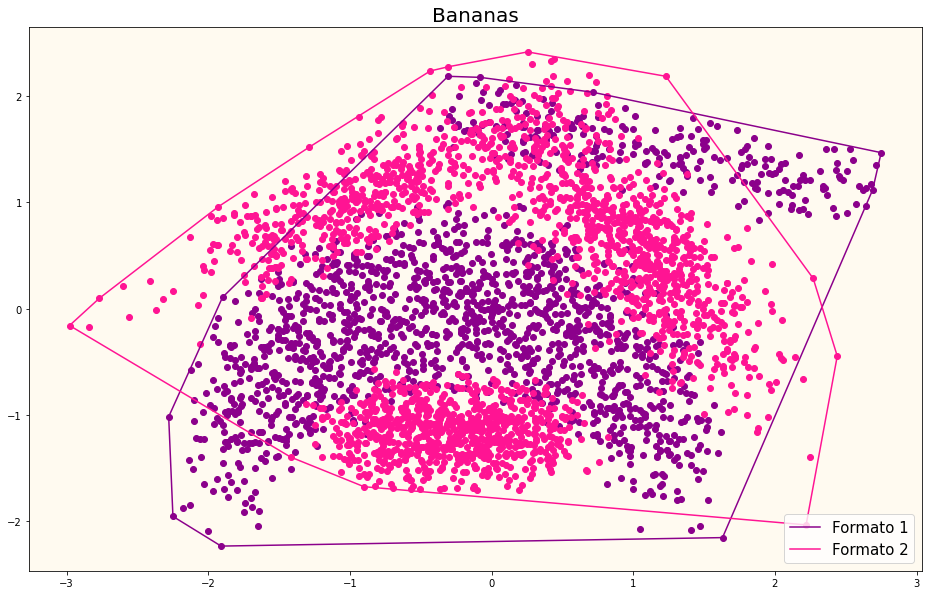

In [84]:
plota_envoltorias(formato1_treino, formato2_treino)
plt.title("Bananas", fontsize = 20)
plt.legend(["Formato 1", "Formato 2"], loc = "lower right", fontsize = 15)

dados_separaveis(formato1_treino,formato2_treino)

Como os dados não são linearmente separáveis, não podemos criar um modelo para o formato das bananas de acordo com esses atributos.

### 2. Flores

Esse conjunto de dados prevê qual o tipo de planta de íris dentre 3 classes distintas. As duas escolhidas para esse experimento foram: Iris-setosa e Iris-versicolor. Os atributos utilizados para análise foram o comprimento da sépala e a largura da pétala.

A seguir, a visualização do dataframe:

In [85]:
df_iris = pd.read_csv('./iris.csv', delimiter=', ')

df_setosa = df_iris[df_iris['Class'] == 'Iris-setosa']
df_versicolor = df_iris[df_iris['Class'] == 'Iris-versicolor']

setosa_treino, setosa_teste = dados_treino_teste(df_setosa, 'SepalLength', 'PetalWidth')
versicolor_treino, versicolor_teste = dados_treino_teste(df_versicolor, 'SepalLength', 'PetalWidth')

df_iris.head()

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


,SepalLength,SepalWidth,PetalLength,PetalWidth,Class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.6,3.1,1.5,0.2,Iris-setosa
3,5.0,3.6,1.4,0.2,Iris-setosa
4,5.4,3.9,1.7,0.4,Iris-setosa


Checando a separabilidade linear das classes:

Dados linearmente separaveis!


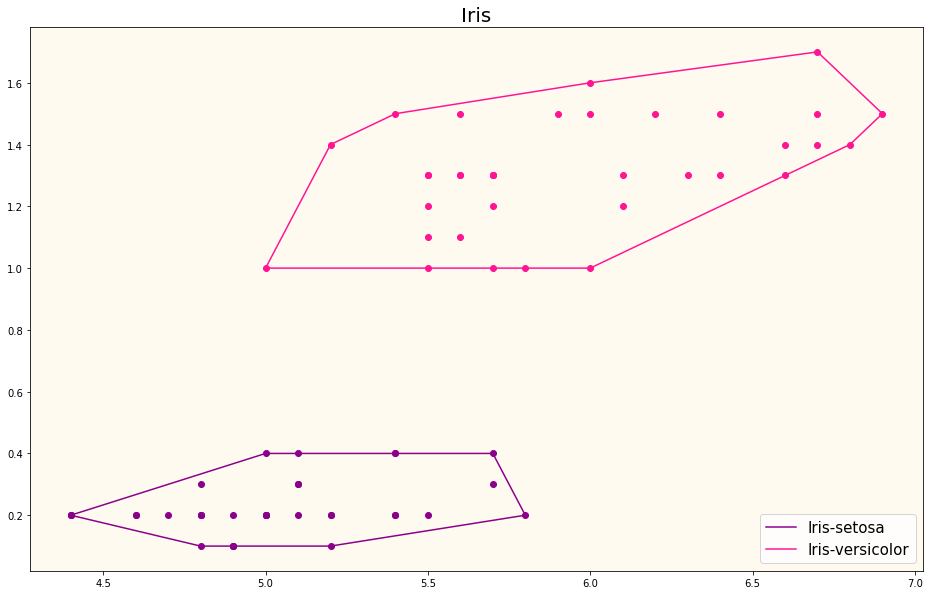

In [86]:
plota_envoltorias(setosa_treino, versicolor_treino)
plt.title("Iris", fontsize = 20)
plt.legend(["Iris-setosa", "Iris-versicolor"], loc = "lower right", fontsize = 15)

dados_separaveis(setosa_treino,versicolor_treino)
plt.show()

Como os dados são linearmente separáveis, é possível criar um modelo para rotular novas amostras:

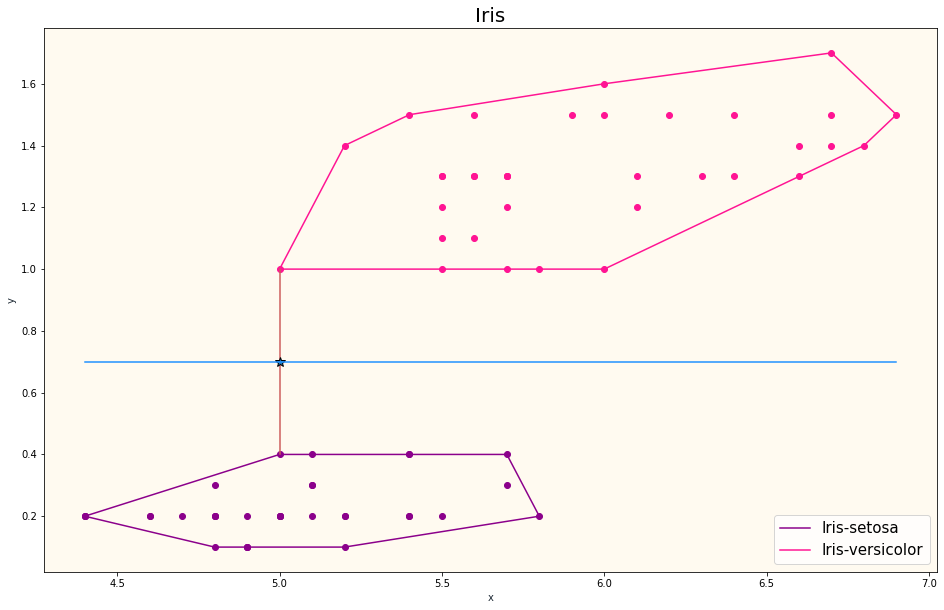

In [87]:
plota_modelo_completo(setosa_treino, versicolor_treino)
plt.title("Iris", fontsize = 20)
plt.legend(["Iris-setosa", "Iris-versicolor"], loc = "lower right", fontsize = 15)

Modelo despoluído:

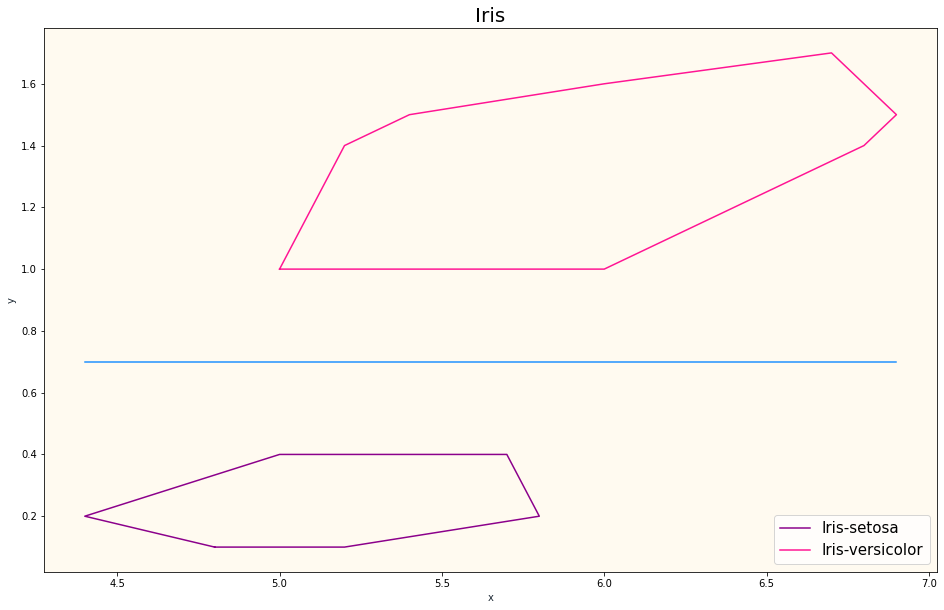

In [88]:
plota_modelo_limpo(setosa_treino, versicolor_treino)
plt.title("Iris", fontsize = 20)
plt.legend(["Iris-setosa", "Iris-versicolor"], loc = "lower right", fontsize = 15)

Cálculo das métricas para avaliação do desempenho do classificador:

In [89]:
original, teste = resultados_teste_e_original(setosa_treino, versicolor_treino, 'Iris-setosa', 'Iris-versicolor', setosa_teste, versicolor_teste)
calcula_metricas(original,teste)

Precision: 1.0000
Recall: 1.0000
Fscore: 1.0000


O modelo criado foi capaz de rotular corretamente todas as amostras de teste, provavelmente porque 30% das instâncias escolhidas correspondem a apenas 30 elementos!

### 3. Sonar: minas vs. rochas

Esse conjunto de dados prevê se um elemento é uma rocha ou mina (cilindro de metal). São informados os sinais obtidos a partir de uma variedade de ângulos de aspectos diferentes. Cada um dos 60 padrões de sinal está na faixa de 0,0 a 1,0 e representa a energia dentro de uma banda de frequência em um determinado período de tempo. Para tentar determinar o modelo foram analisados os padrões 4 e 42.

A seguir, a visualização do dataframe:

In [90]:
df_sonar = pd.read_csv('./sonar.csv', delimiter=', ')

df_rocha = df_sonar[df_sonar['Type'] == 'R']
df_mina = df_sonar[df_sonar['Type'] == 'M']

rocha_treino, rocha_teste = dados_treino_teste(df_rocha, 'Band42', 'Band4')
mina_treino, mina_teste = dados_treino_teste(df_mina, 'Band42', 'Band4')

df_sonar.head()

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


,Band1,Band2,Band3,Band4,Band5,Band6,Band7,Band8,Band9,Band10,...,Band52,Band53,Band54,Band55,Band56,Band57,Band58,Band59,Band60,Type
0,0.020,0.037,0.043,0.021,0.095,0.099,0.154,0.160,0.311,0.211,...,0.003,0.006,0.016,0.007,0.017,0.018,0.008,0.009,0.003,R
1,0.045,0.052,0.084,0.069,0.118,0.258,0.216,0.348,0.334,0.287,...,0.008,0.009,0.005,0.009,0.019,0.014,0.005,0.005,0.004,R
2,0.026,0.058,0.110,0.108,0.097,0.228,0.243,0.377,0.560,0.619,...,0.023,0.017,0.010,0.018,0.024,0.032,0.016,0.010,0.008,R
3,0.010,0.017,0.062,0.020,0.020,0.037,0.110,0.128,0.060,0.126,...,0.012,0.004,0.015,0.008,0.007,0.005,0.004,0.004,0.012,R
4,0.076,0.067,0.048,0.039,0.059,0.065,0.121,0.247,0.356,0.446,...,0.003,0.005,0.010,0.011,0.002,0.007,0.005,0.011,0.009,R


Checando a separabilidade linear dos dados:

Dados nao linearmente separaveis!


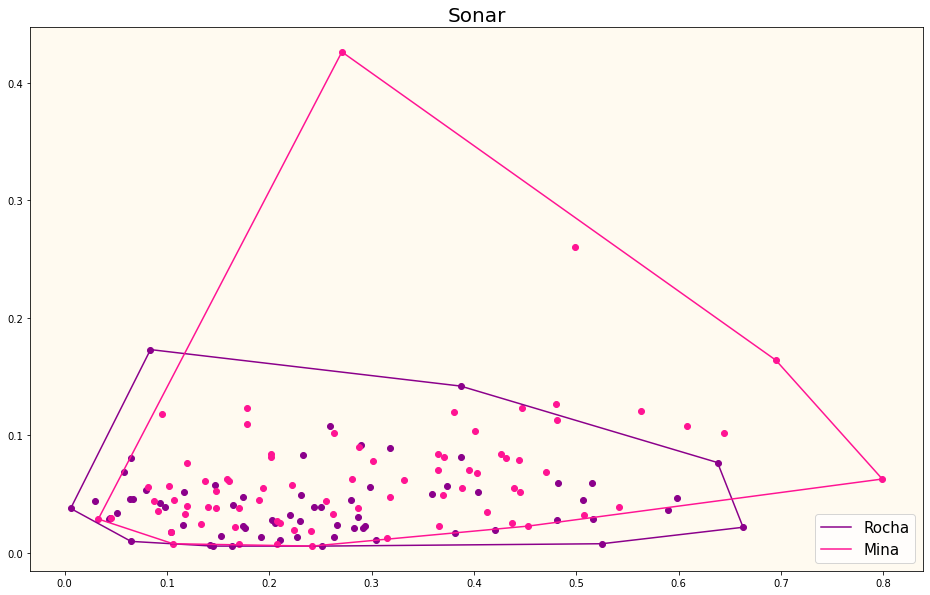

In [91]:
plota_envoltorias(rocha_treino, mina_treino)
plt.title("Sonar", fontsize = 20)
plt.legend(["Rocha", "Mina"], loc = "lower right", fontsize = 15)

dados_separaveis(rocha_treino,mina_treino)

Como os dados não são linearmente separáveis, não podemos criar um modelo para rotular se um elemento é rocha ou mina, de acordo com esses atributos.

### 4. Abalone

Esse conjunto de dados prevê a idade do abalone (tipo de molusco) contando o número de aneis da casca através de um microscópio. Esse número varia de 1 a 28 e, para criar as classes consideramos 4 e 19 aneis. Os atributos usados para tentar determinar o modelo foram o diâmetro e a altura dos animais.

A seguir, a visualização do dataframe:



In [92]:
df_abalone = pd.read_csv('./abalone.csv', delimiter=', ')

df_novo = df_abalone[df_abalone['Rings'] == 4]
df_velho = df_abalone[df_abalone['Rings'] == 19]

novo_treino, novo_teste = dados_treino_teste(df_novo, 'Diameter', 'Height')
velho_treino, velho_teste = dados_treino_teste(df_velho, 'Diameter', 'Height')

df_abalone.head()

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


Checando a separabilidade linear dos dados:

Dados linearmente separaveis!


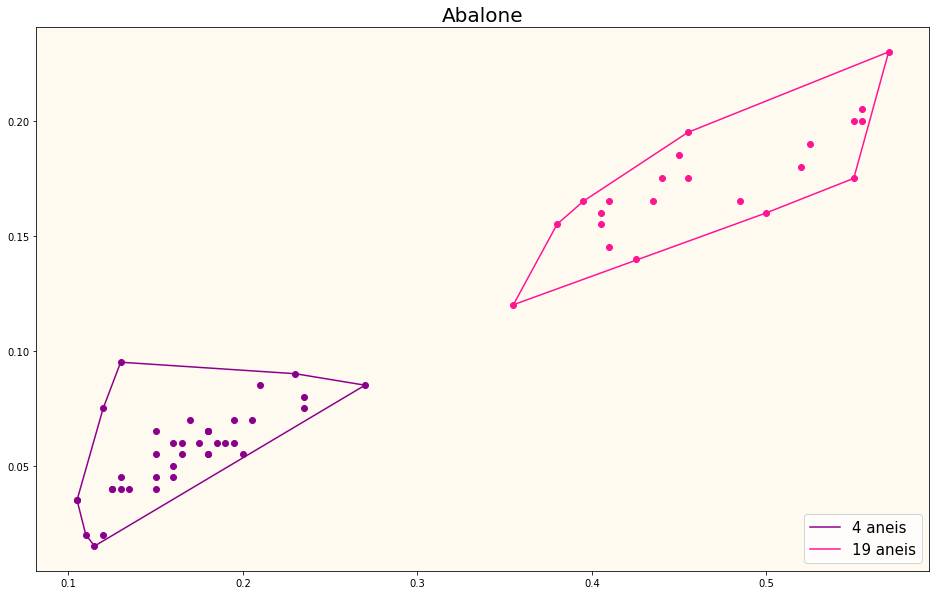

In [93]:
plota_envoltorias(novo_treino, velho_treino)
plt.title("Abalone", fontsize = 20)
plt.legend(["4 aneis", "19 aneis"], loc = "lower right", fontsize = 15)

dados_separaveis(novo_treino,velho_treino)

Como os dados são linearmente separáveis, é possível criar um modelo para classificar esses dados:

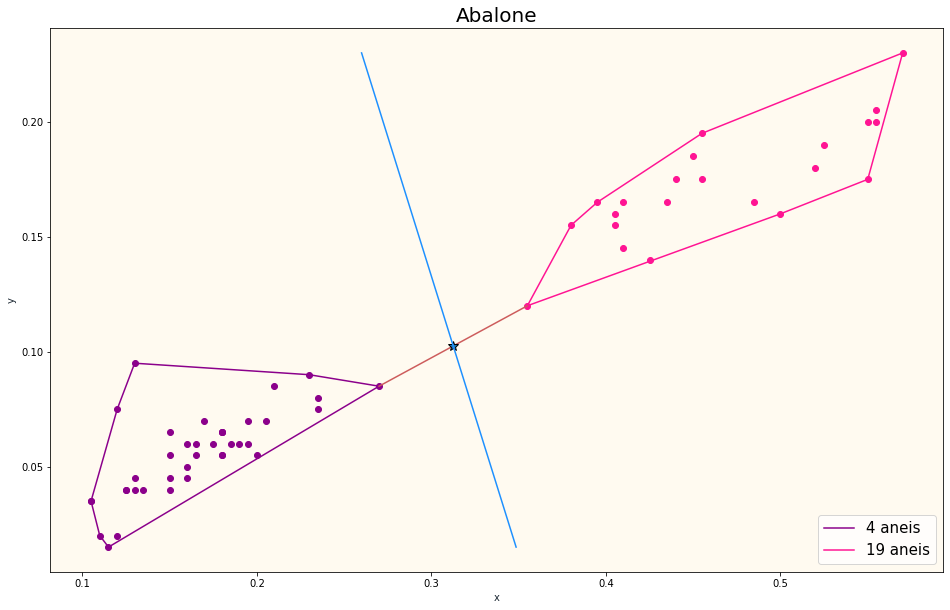

In [94]:
plota_modelo_completo(novo_treino, velho_treino)
plt.title("Abalone", fontsize = 20)
plt.legend(["4 aneis", "19 aneis"], loc = "lower right", fontsize = 15)

Modelo despoluído:

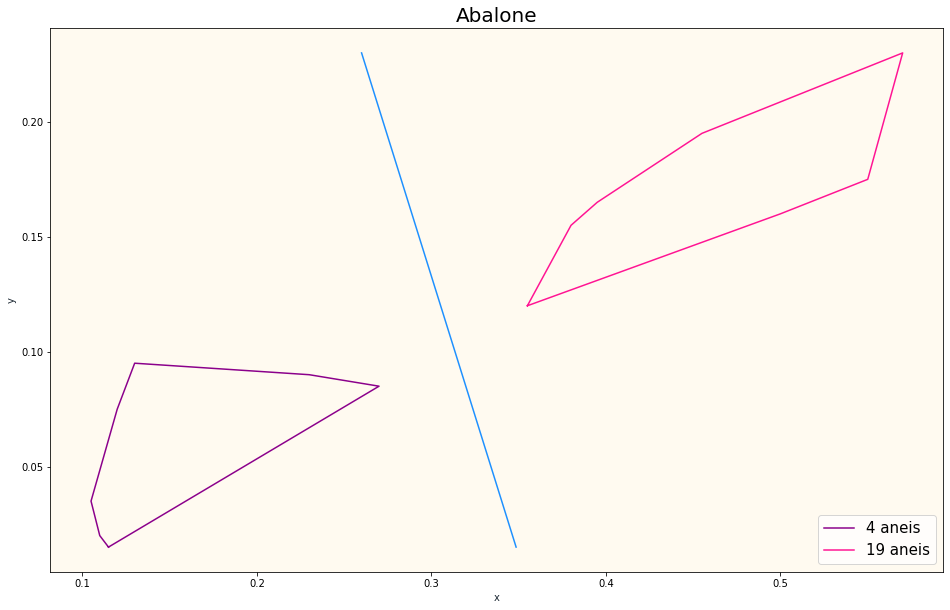

In [95]:
plota_modelo_limpo(novo_treino, velho_treino)
plt.title("Abalone", fontsize = 20)
plt.legend(["4 aneis", "19 aneis"], loc = "lower right", fontsize = 15)

Cálculo das métricas para avaliação do desempenho do classificador:

In [96]:
original, teste = resultados_teste_e_original(novo_treino, velho_treino, 4, 19, novo_teste, velho_teste)
calcula_metricas(original,teste)

Precision: 1.0000
Recall: 1.0000
Fscore: 1.0000


O modelo criado foi capaz de rotular corretamente todas as amostras de teste, provavelmente porque 30% das instâncias escolhidas correspondem a apenas 56 elementos!

### 5. Magic

Este conjunto de dados prevê estatisticamente o tipo de partículas de alta energia (g ou h) a partir de imagens registradas por um telescópio. Os atributos utilizados para tentar construir o modelo foram FAsym (distância do pixel mais alto ao centro) e FLength (eixo principal da elipse).

A seguir, a visualização do dataframe:

In [97]:
df_magic = pd.read_csv('./magic.csv', delimiter=',')

df_g = df_magic[df_magic['Class'] == 'g']
df_h = df_magic[df_magic['Class'] == 'h']

g_treino, g_teste = dados_treino_teste(df_g, 'FLength', 'FDist')
h_treino, h_teste = dados_treino_teste(df_h, 'FLength', 'FDist')
df_magic.head()

,FLength,FWidth,FSize,FConc,FConc1,FAsym,FM3Long,FM3Trans,FAlpha,FDist,Class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,g
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,g
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,g
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,g
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,g


Checando a separabilidade linear:

Dados nao linearmente separaveis!


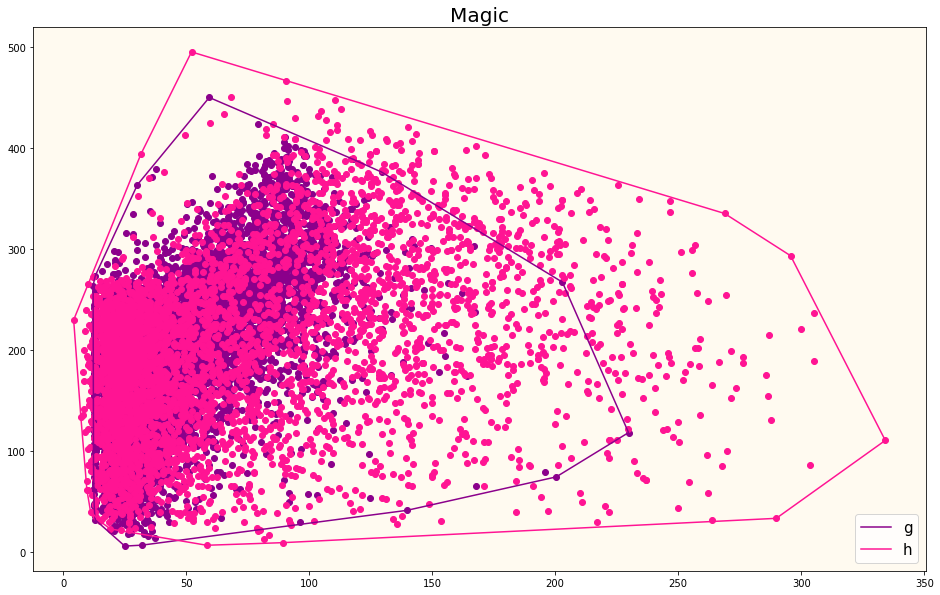

In [98]:
plota_envoltorias(g_treino, h_treino)
plt.title("Magic", fontsize = 20)
plt.legend(["g", "h"], loc = "lower right", fontsize = 15)

dados_separaveis(g_treino,h_treino)

Como os dados não são linearmente separáveis, não podemos criar um modelo para rotular o tipo de uma partícula de alta energia, de acordo com esses atributos.

### 6. Shuttle

Esse conjunto de dados prevê a melhor forma de uma espaçonave pousar. As classes variam de 1 a 7 e as utilizadas serão 2 (First person view close) e 6 (BPV close). As características não identificadas usadas para determinar o tipo de pouso escolhidas foram A2 e A9.

A seguir, a visualização do dataframe:




In [99]:
df_shuttle = pd.read_csv('./shuttle.csv', delimiter=',')

df_fpv = df_shuttle[df_shuttle['Class'] == 2]
df_bpv = df_shuttle[df_shuttle['Class'] == 6]

fpv_treino, fpv_teste = dados_treino_teste(df_fpv, 'A2', 'A7')
bpv_treino, bpv_teste = dados_treino_teste(df_bpv, 'A2', 'A7')
df_shuttle.head()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,Class
0,55,0,92,0,0,26,36,92,56,4
1,53,0,82,0,52,-5,29,30,2,1
2,37,0,76,0,28,18,40,48,8,1
3,37,0,79,0,34,-26,43,46,2,1
4,85,0,88,-4,6,1,3,83,80,5


Checando a separabilidade linear dos dados:

Dados linearmente separaveis!


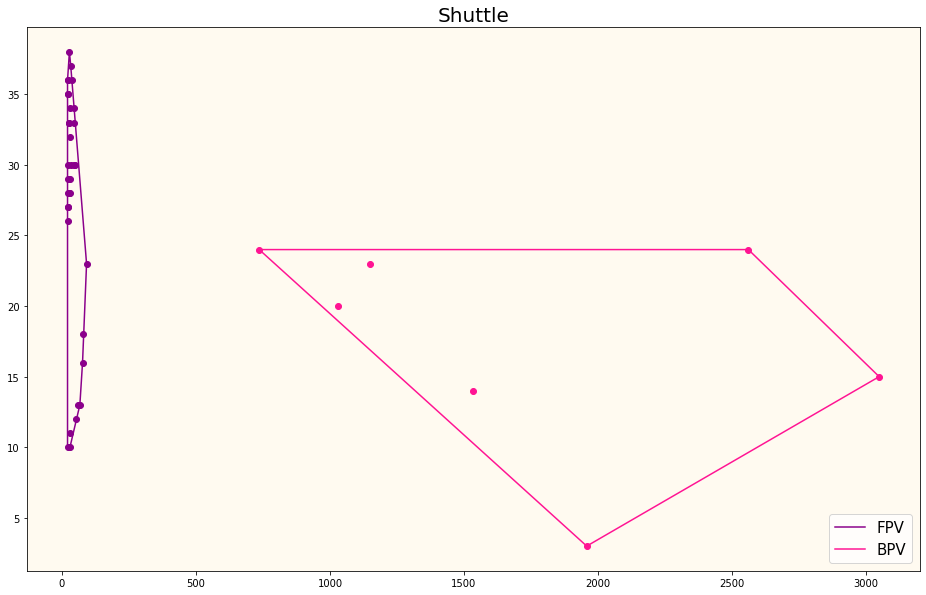

In [100]:
plota_envoltorias(fpv_treino, bpv_treino)
plt.title("Shuttle", fontsize = 20)
plt.legend(["FPV", "BPV"], loc = "lower right", fontsize = 15)

dados_separaveis(fpv_treino, bpv_treino)

Como os dados são linearmente separáveis, é possível criar um modelo para classificá-los:

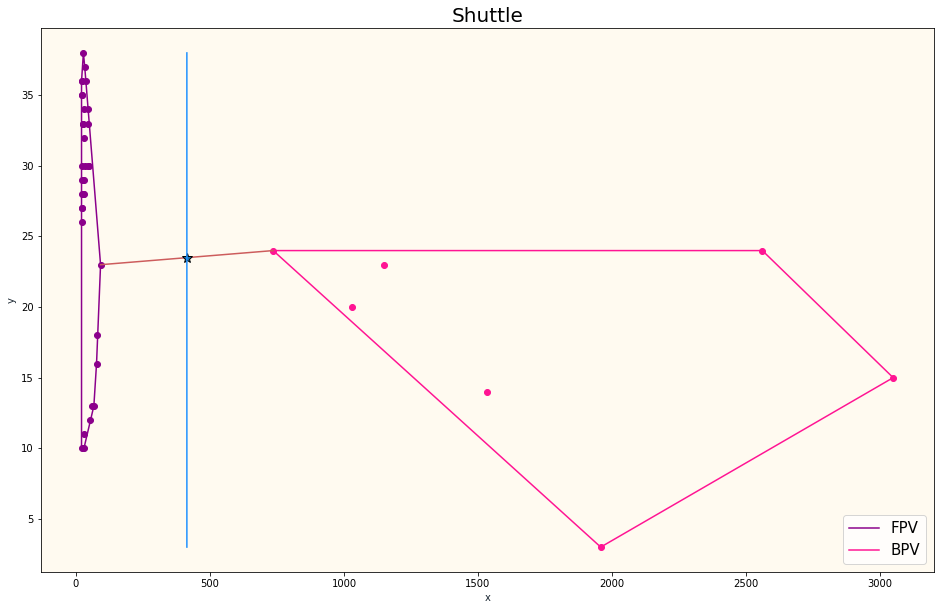

In [101]:
plota_modelo_completo(fpv_treino, bpv_treino)
plt.title("Shuttle", fontsize = 20)
plt.legend(["FPV", "BPV"], loc = "lower right", fontsize = 15)

Modelo despoluído:

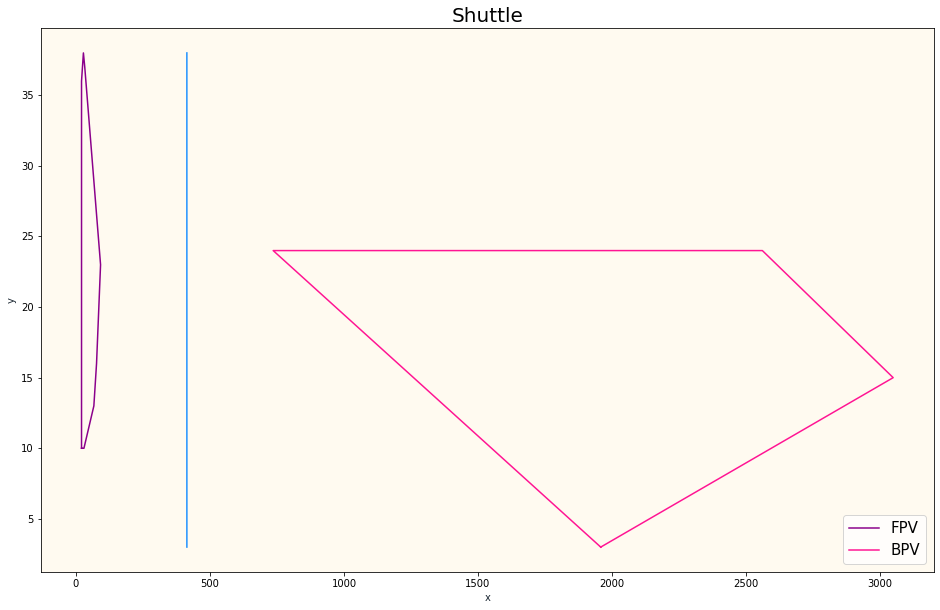

In [102]:
plota_modelo_limpo(fpv_treino, bpv_treino)
plt.title("Shuttle", fontsize = 20)
plt.legend(["FPV", "BPV"], loc = "lower right", fontsize = 15)

Cálculo das métricas para avaliação do desempenho do classificador:

In [103]:
original, teste = resultados_teste_e_original(fpv_treino, bpv_treino, 'A9', 'A2', fpv_teste, bpv_teste)
calcula_metricas(original,teste)

Precision: 1.0000
Recall: 1.0000
Fscore: 1.0000


O modelo criado foi capaz de rotular corretamente todas as amostras de teste, provavelmente porque 30% das instâncias escolhidas correspondem a apenas 18 elementos!

### 7. Censo

Esse conjunto de dados do Censo foi extraído dos dados do censo dos Estados Unidos de 1994. Ele prevê se a renda do cidadão ultrapassa ou não 50 mil dólares por ano. As características usadas para essa previsão são infomrações sociais e econômicas. As escolhidas para análise foram os atributos 5 e 24 não identificados.

A seguir, a visualização do dataframe:

In [104]:
df_census = pd.read_csv('./census.csv', delimiter=',')

df_50mais = df_census[df_census['Class'] == '-_50000.']
df_50menos = df_census[df_census['Class'] == '50000+.']

mais_treino, mais_teste = dados_treino_teste(df_50mais, 'Atr-24', 'Atr-5')
menos_treino, menos_teste = dados_treino_teste(df_50menos, 'Atr-24', 'Atr-5')
df_census.head()

,Atr-0,Atr-1,Atr-2,Atr-3,Atr-4,Atr-5,Atr-6,Atr-7,Atr-8,Atr-9,...,Atr-32,Atr-33,Atr-34,Atr-35,Atr-36,Atr-37,Atr-38,Atr-39,Atr-40,Class
0,58,Self-employed-not_incorporated,4,34,Some_college_but_no_degree,0,Not_in_universe,Divorced,Construction,Precision_production_craft_&_repair,...,United-States,United-States,United-States,Native-_Born_in_the_United_States,0,Not_in_universe,2,52,94,-_50000.
1,9,Not_in_universe,0,0,Children,0,Not_in_universe,Never_married,Not_in_universe_or_children,Not_in_universe,...,United-States,United-States,United-States,Native-_Born_in_the_United_States,0,Not_in_universe,0,0,94,-_50000.
2,10,Not_in_universe,0,0,Children,0,Not_in_universe,Never_married,Not_in_universe_or_children,Not_in_universe,...,United-States,United-States,United-States,Native-_Born_in_the_United_States,0,Not_in_universe,0,0,94,-_50000.
3,42,Private,34,3,Bachelors_degree(BA_AB_BS),0,Not_in_universe,Married-civilian_spouse_present,Finance_insurance_and_real_estate,Executive_admin_and_managerial,...,United-States,United-States,United-States,Native-_Born_in_the_United_States,0,Not_in_universe,2,52,94,-_50000.
4,34,Private,4,37,Some_college_but_no_degree,0,Not_in_universe,Married-civilian_spouse_present,Construction,Machine_operators_assmblrs_&_inspctrs,...,United-States,United-States,United-States,Native-_Born_in_the_United_States,0,Not_in_universe,2,52,94,-_50000.


Checando a separabilidade linear dos dados:

Dados nao linearmente separaveis!


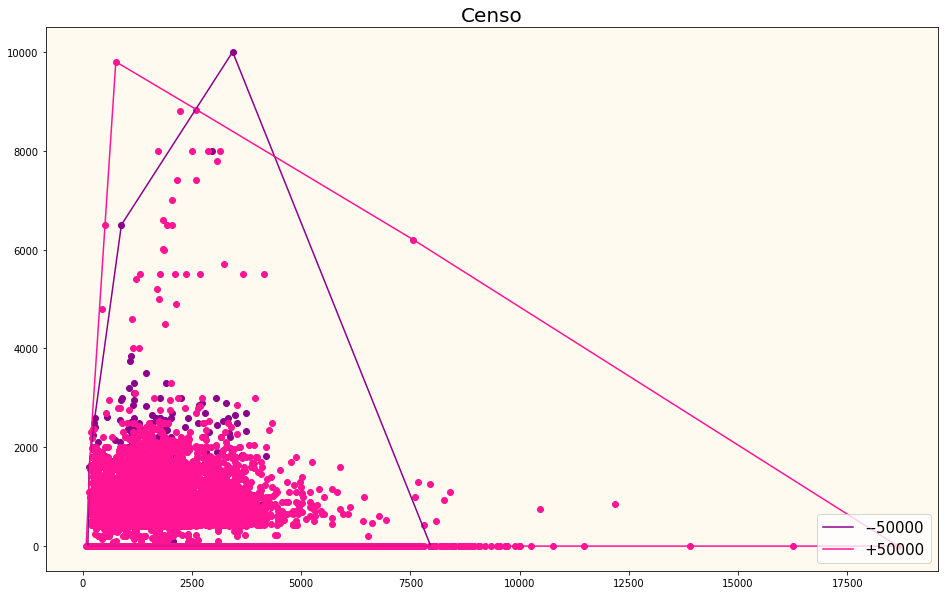

In [105]:
plota_envoltorias(menos_treino, mais_treino)
plt.title("Censo", fontsize = 20)
plt.legend(["--50000", "+50000"], loc = "lower right", fontsize = 15)

dados_separaveis(menos_treino, mais_treino)

Como os dados não são linearmente separáveis, não podemos criar um modelo para decidir se um indivíduo ganha mais ou menos de 50 mil dólares por ano, de acordo com esses atributos.

### 8. Textura

Esse conjunto de dados prevê o tipo de textura de uma superfície. Entre elas há gramado, couro de bezerro, papel artesanal, lona de algodão, etc. As duas classes escolhidas, mas não identificadas foram 12 e 14. As características para tentarmos a previsão foram apresentadas ao longo de 40 atributos relacionados a características angulares e de temperatura do local. 
As escolhidas para análise foram A1 e A40.

A seguir, a visualização do dataframe:

In [106]:
df_texture = pd.read_csv('./texture.csv', delimiter=',')

df_textura1 = df_texture[df_texture['Class'] == 12]
df_textura2 = df_texture[df_texture['Class'] == 14]

textura1_treino, textura1_teste = dados_treino_teste(df_textura1, 'A1', 'A40')
textura2_treino, textura2_teste = dados_treino_teste(df_textura2, 'A1', 'A40')
df_texture.head()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,...,A32,A33,A34,A35,A36,A37,A38,A39,A40,Class
0,-1.223,-0.798,-0.867,-0.639,-0.545,-0.412,-0.795,-0.629,-0.547,-0.868,...,-0.766,-0.555,-0.714,-0.545,-0.587,-0.871,-0.620,-0.568,-0.607,2
1,-1.410,-1.029,-1.013,-0.895,-0.762,-0.676,-1.043,-0.851,-0.775,-1.037,...,-0.919,-0.770,-0.847,-0.663,-0.723,-1.013,-0.748,-0.698,-0.817,2
2,-1.107,-0.649,-0.629,-0.492,-0.367,-0.298,-0.682,-0.478,-0.395,-0.681,...,-0.692,-0.445,-0.588,-0.371,-0.368,-0.746,-0.457,-0.379,-0.469,2
3,-1.270,-0.855,-0.958,-0.707,-0.619,-0.469,-0.872,-0.705,-0.620,-0.988,...,-0.829,-0.719,-0.774,-0.617,-0.688,-0.937,-0.693,-0.657,-0.779,2
4,-1.331,-0.862,-0.761,-0.689,-0.498,-0.361,-0.857,-0.600,-0.496,-0.779,...,-0.861,-0.571,-0.784,-0.545,-0.562,-0.952,-0.642,-0.578,-0.648,2


Checando a separabilidade linear dos dados:

Dados linearmente separaveis!


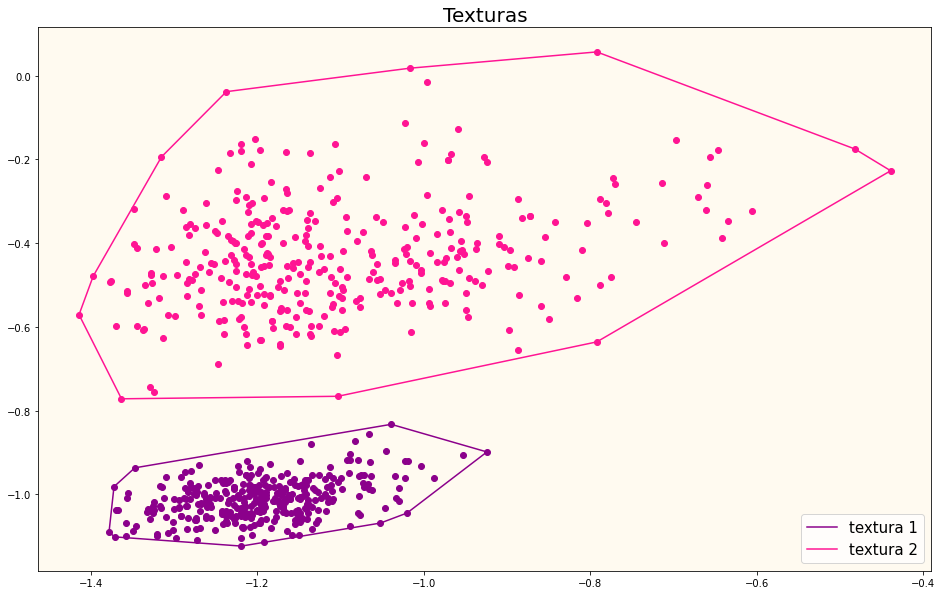

In [107]:
plota_envoltorias(textura1_treino, textura2_treino)
plt.title("Texturas", fontsize = 20)
plt.legend(["textura 1", "textura 2"], loc = "lower right", fontsize = 15)

dados_separaveis(textura1_treino, textura2_treino)

Como os dados são linearmente separáveis, é possível criar um modelo para classificá-los:

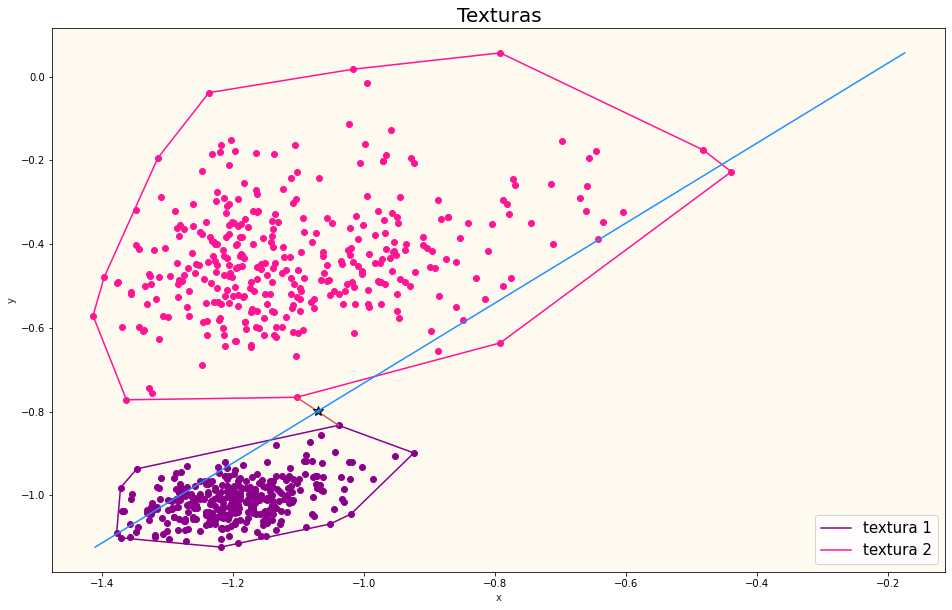

In [108]:
plota_modelo_completo(textura1_treino, textura2_treino)
plt.title("Texturas", fontsize = 20)
plt.legend(["textura 1", "textura 2"], loc = "lower right", fontsize = 15)

Modelo despoluído:

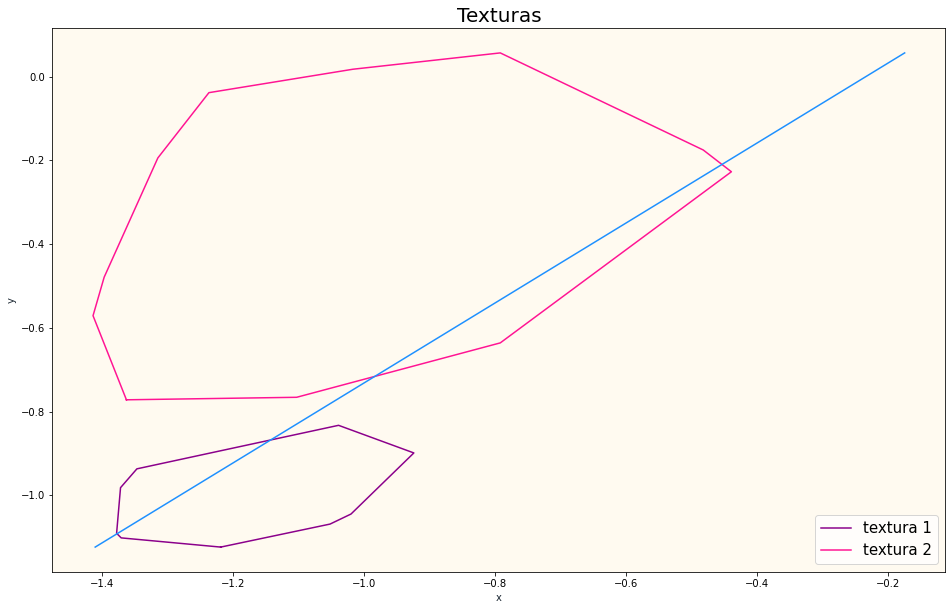

In [109]:
plota_modelo_limpo(textura1_treino, textura2_treino)
plt.title("Texturas", fontsize = 20)
plt.legend(["textura 1", "textura 2"], loc = "lower right", fontsize = 15)

Cálculo das métricas para avaliação do desempenho do classificador:

In [110]:
original, teste = resultados_teste_e_original(textura1_treino, textura2_treino, 'A1', 'A40', textura1_teste, textura2_teste)
calcula_metricas(original,teste)

Precision: 0.9467
Recall: 0.9467
Fscore: 0.9467


O modelo criado foi capaz de rotular corretamente 94,67% das amostras de teste!

### 9. Twonorm

Este conjunto de dados classifica problemas em duas classes extraídas de uma distribuição normal multivariada. A primeira tem média (a,a,...,a), enquanto a segunda possui média (-a,-a,...,-a) = 2/sqrt(20). Os atributos usados para tentar a previsão são suas 20 dimensões.

A seguir, a visualização do dataframe:

In [111]:
df_twonorm = pd.read_csv('./twonorm.csv', delimiter=', ')

df_media1 = df_twonorm[df_twonorm['Class'] == 0]
df_media2 = df_twonorm[df_twonorm['Class'] == 1]

media1_treino, media1_teste = dados_treino_teste(df_media1, 'A12', 'A8')
media2_treino, media2_teste = dados_treino_teste(df_media2, 'A12', 'A8')
df_twonorm.head()

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,...,A12,A13,A14,A15,A16,A17,A18,A19,A20,Class
0,-1.2036,-2.6240,0.5963,1.3859,-1.3597,0.6758,1.0008,-0.9589,-1.3487,-0.5572,...,-1.1223,-0.1817,-1.3170,-0.3551,-1.4220,0.1983,-3.0514,-1.0650,-0.8541,1
1,0.1713,-0.1669,-0.4155,-0.9974,-0.9459,-1.2382,-1.4933,-0.3869,0.6450,-0.6253,...,-2.4557,-0.5912,-0.9731,-1.6570,-2.0039,-1.3395,-1.1801,1.3244,0.0202,1
2,0.7743,-0.6060,-1.9338,-0.3614,0.3864,-1.8636,-1.4551,-1.2079,-0.5478,-1.1045,...,0.5462,-0.2295,-1.6227,0.6551,-1.1460,0.9491,-2.7570,-1.1497,0.0191,1
3,-1.2444,1.0990,-1.4684,-1.7003,0.4510,-0.9695,-0.5761,0.0877,0.1058,-1.9614,...,-0.8800,1.0000,-1.7560,-0.6727,0.6034,-0.6858,-0.9101,0.0747,1.1082,1
4,-0.5520,0.3249,0.7253,0.2089,0.3148,-0.2104,0.8060,-0.3111,-2.3584,1.4880,...,0.9096,-0.0908,-0.4096,1.5287,-0.1960,0.3843,0.1541,-0.2981,0.5216,1


Checando a separabilidade linear:

Dados nao linearmente separaveis!


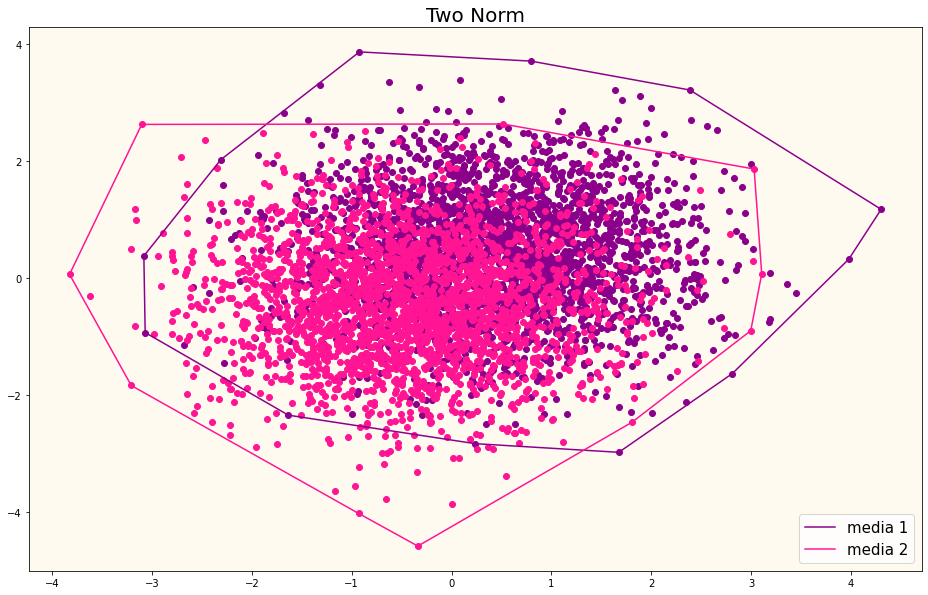

In [112]:
plota_envoltorias(media1_treino, media2_treino)
plt.title("Two Norm", fontsize = 20)
plt.legend(["media 1", "media 2"], loc = "lower right", fontsize = 15)

dados_separaveis(media1_treino,media2_treino)

Como os dados não são linearmente separáveis, não podemos criar um modelo para decidir qual a média do problema de acordo com esses atributos.

### 10. Segmentos

Esse conjunto de dados contém 7 classes correspondentes a 7 imagens externas. As escolhidas para tentar a criação do modelo foram 2 e 6. Os atributos usados foram Intensity-Mean (a média sobre a região de (R + G + B)/3) e Hedge-Mean (contraste de pixels adjacentes verticalmente).

A seguir, a visualização do dataframe:

In [113]:
df_segment = pd.read_csv('./segment.csv', delimiter=', ')

df_classe1 = df_segment[df_segment['Class'] == 1]
df_classe6 = df_segment[df_segment['Class'] == 6]

classe1_treino, classe1_teste = dados_treino_teste(df_classe1, 'Intensity-mean', 'Hedge-mean')
classe6_treino, classe6_teste = dados_treino_teste(df_classe6, 'Intensity-mean', 'Hedge-mean')
df_segment.head()

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


,Region-centroid-col,Region-centroid-row,Region-pixel-count,Short-line-density-5,Short-line-density-2,Vedge-mean,Vegde-sd,Hedge-mean,Hedge-sd,Intensity-mean,Rawred-mean,Rawblue-mean,Rawgreen-mean,Exred-mean,Exblue-mean,Exgreen-mean,Value-mean,Saturatoin-mean,Hue-mean,Class
0,218.0,178.0,9.0,0.111111,0.0,0.833333,0.547722,1.111109,0.544331,59.629630,52.444443,75.222220,51.222220,-21.555555,46.777780,-25.222221,75.222220,0.318996,-2.040554,6
1,113.0,130.0,9.0,0.000000,0.0,0.277778,0.250924,0.333333,0.365148,0.888889,0.000000,2.555556,0.111111,-2.666667,5.000000,-2.333333,2.555556,1.000000,-2.123254,3
2,32.0,173.0,9.0,0.000000,0.0,1.722222,1.781593,9.000000,6.749488,43.592594,39.555557,52.888890,38.333336,-12.111111,27.888890,-15.777778,52.888890,0.266914,-1.998857,6
3,61.0,197.0,9.0,0.000000,0.0,1.444444,1.515353,2.611111,1.925463,49.592594,44.222220,61.555557,43.000000,-16.111110,35.888890,-19.777779,61.555557,0.302925,-2.022274,6
4,149.0,185.0,9.0,0.000000,0.0,1.555555,1.068055,3.055555,1.925463,49.333332,45.333332,59.555557,43.111110,-12.000000,30.666666,-18.666666,59.555557,0.275889,-1.952770,6


Checando a separabilidade linear dos dados:

Dados linearmente separaveis!


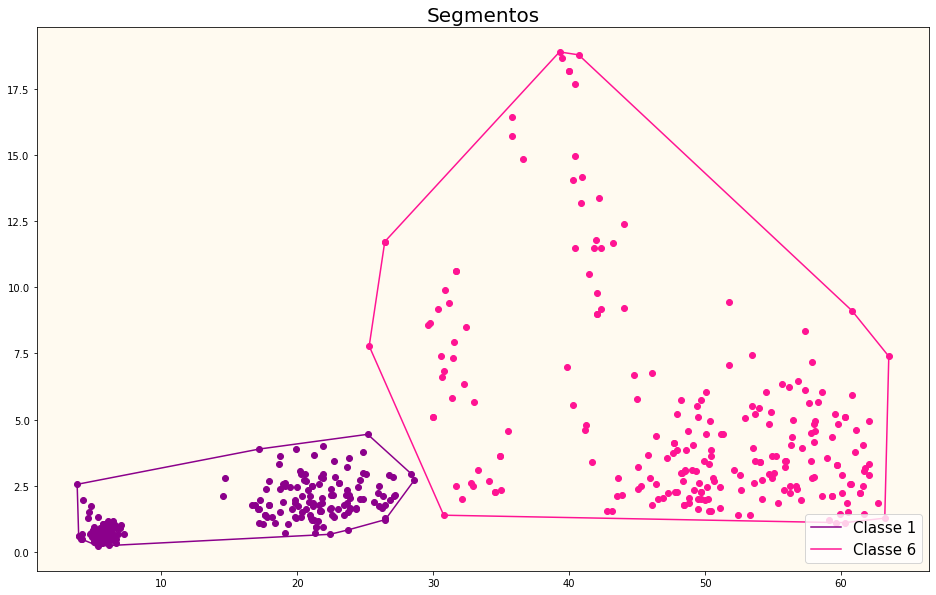

In [114]:
plota_envoltorias(classe1_treino, classe6_treino)
plt.title("Segmentos", fontsize = 20)
plt.legend(["Classe 1", "Classe 6"], loc = "lower right", fontsize = 15)

dados_separaveis(classe1_treino, classe6_treino)

Como os dados são linearmente separáveis, é possível criar um modelo para classificá-los:

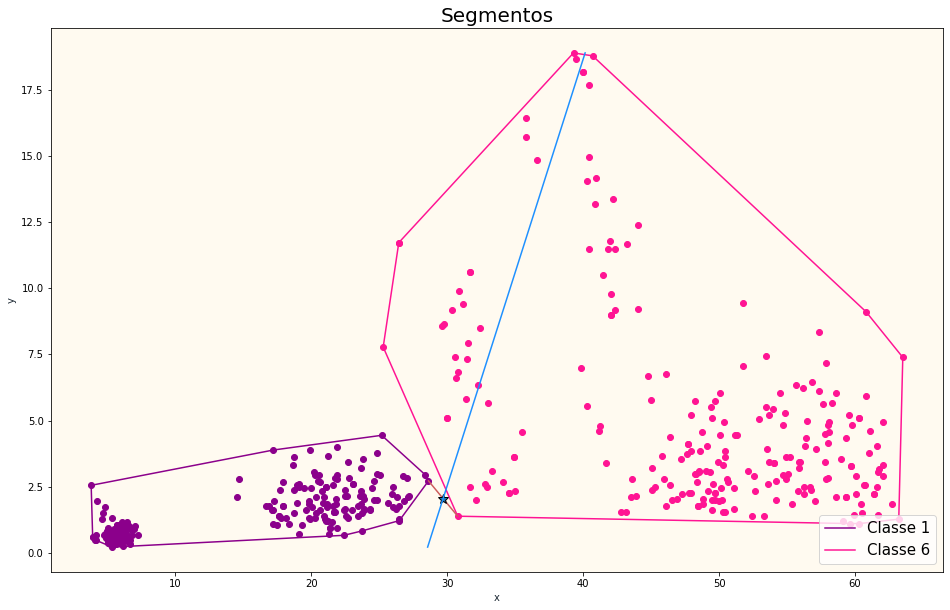

In [115]:
plota_modelo_completo(classe1_treino, classe6_treino)
plt.title("Segmentos", fontsize = 20)
plt.legend(["Classe 1", "Classe 6"], loc = "lower right", fontsize = 15)

Modelo despoluído

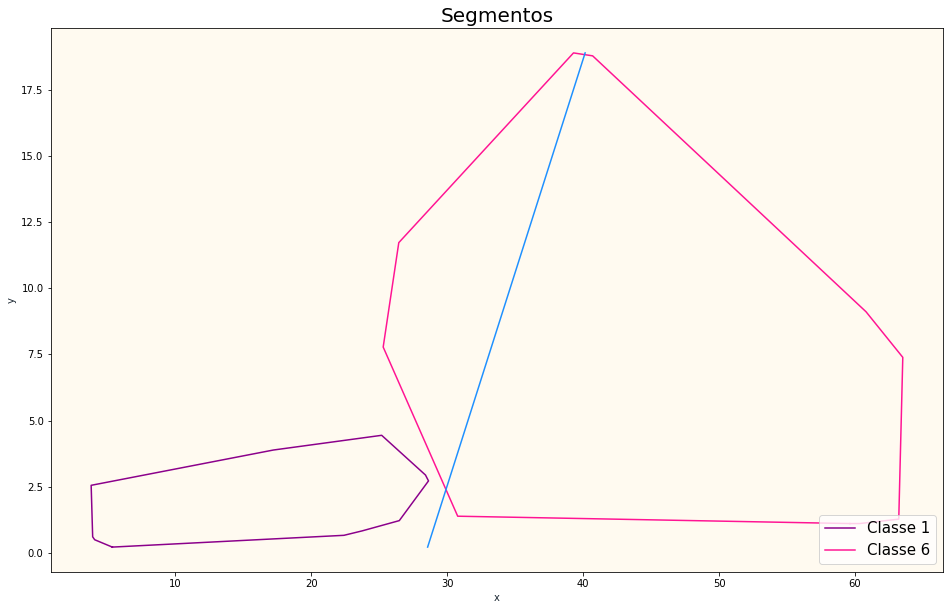

In [116]:
plota_modelo_limpo(classe1_treino, classe6_treino)
plt.title("Segmentos", fontsize = 20)
plt.legend(["Classe 1", "Classe 6"], loc = "lower right", fontsize = 15)

Cálculo das métricas para avaliação do desempenho do classificador:

In [117]:
original, teste = resultados_teste_e_original(classe1_treino, classe6_treino, 1 , 6 , classe1_teste, classe6_teste)
calcula_metricas(original,teste)

Precision: 0.9697
Recall: 0.9697
Fscore: 0.9697


O modelo criado foi capaz de rotular corretamente 96,97% das amostras de teste!

# Conclusões

O objetivo desse trabalho foi o desenvolvimento de aspectos práticos dos algoritmos de geometria computacional, especificamente, os de envoltória convexa e varredura linear para identificação de interseção de segmentos.

 A aplicação desses algoritmos no contexto de classificação em aprendizado de máquina supervisionado e a possibilidade de realização de experimentos com dados reais juntamente com a avaliação do desempenho do modelo criado tornou o trabalho ainda mais desafiador e interessante.

 Dessa forma, a realização do trabalho prático foi essencial para a fixação do aprendizado em relação aos algoritmos geométricos e bastante intrigante pelo contato com novas ferramentas.